# Other Algorithms

In this notebook, the robustness of the method chosen in the Callaham paper is tested by exploring other possible algorithms for identifying the dominant balance regimes.

First, we do the same preprocessing done for the Boundary_Layer notebook. We'll get the data and the derivatives and obtain the equation space representation of the terms.

In [1]:
import numpy as np
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt
import sys
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d


# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs


import matplotlib as mpl

mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")
mpl.rc("figure", figsize=(15, 3))
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
%config InlineBackend.figure_format = 'retina'


from matplotlib.colors import ListedColormap

# Seaborn colormap
import seaborn as sns

sns_list = sns.color_palette("deep").as_hex()
sns_list.insert(0, "#ffffff")
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

mpl_colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

# 1. Preprocessing

## a. Load the data

In [2]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [3]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u = np.array(file["um"])
v = np.array(file["vm"])
p = np.array(file["pm"])
Ruu = np.array(file["uum"]) - u**2
Ruv = np.array(file["uvm"]) - u * v
Rvv = np.array(file["uvm"]) - v**2

In [4]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [5]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

Dy = sparse.diags([-1, 1], [-1, 1], shape=(ny, ny)).toarray()

# Get 2nd order forward/backwards at the boundaries
Dy[0, :3] = np.array([-3, 4, -1])
Dy[-1, -3:] = np.array([1, -4, 3])

for i in range(ny - 1):
    Dy[i, :] = Dy[i, :] / (2 * dy[i])
Dy[-1, :] = Dy[-1, :] / (2 * dy[-1])

# Repeat this for the x-direction
Dy = sparse.block_diag([Dy for i in range(nx)])  # Creates a block diagonal matrix
# with the Dy matrix on the diagonal

Dx = sparse.diags([-1, 1], [-ny, ny], shape=(nx * ny, nx * ny))
Dx = sparse.lil_matrix(Dx)

# Get 2nd order forwards/backwards with boundary conditions
for i in range(ny):
    Dx[i, i] = -3
    Dx[i, ny + i] = 4
    Dx[i, 2 * ny + i] = -1
    Dx[-(i + 1), -(i + 1)] = 3
    Dx[-(i + 1), -(ny + i + 1)] = -4
    Dx[-(i + 1), -(2 * ny + i + 1)] = 1
Dx = Dx / (2 * dx)

Dx = sparse.csr_matrix(Dx)
Dy = sparse.csr_matrix(Dy)

Dxx = 2 * (Dx @ Dx)
Dyy = 2 * (Dy @ Dy)

In [6]:
# Flatten arrays for matrix multiplication, using fortran ordering
u = u.flatten("F")
v = v.flatten("F")
p = p.flatten("F")
Ruu = Ruu.flatten("F")
Ruv = Ruv.flatten("F")

# Get derivatives
ux = Dx @ u
uy = Dy @ u
vx = Dx @ v
vy = Dy @ v
px = Dx @ p
py = Dy @ p
lap_u = (Dxx + Dyy) @ u
Ruux = Dx @ Ruu
Ruvy = Dy @ Ruv

## c. Equation space representation

In [7]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [8]:
# Get terms stored as features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# Other algorithms

# 1. Spectral Clustering


## a. Train and predict model

In [9]:
# Initialise the Spectral Clustering model
nc = 6  # Number of clusters
seed = np.random.randint(2**32)
seed = 3696299933  #  Keep a seed for debugging/plotting
print(seed)
model = SpectralClustering(n_clusters=nc, random_state=seed)

3696299933


In [10]:
# Get a subset of the data
ny_sc = 25
nx_sc = 332

In [11]:
# Get subset of u variable and data
# u_sc = (
#     u.reshape(nx, ny, order="F")[:: int(nx // nx_sc), :: int(ny // ny_sc)]
#     .copy()
#     .flatten("F")
# )
# features_sc = (
#     features.reshape(nx, ny, nfeatures)[:: int(nx // nx_sc), :: int(ny // ny_sc), :]
#     .reshape(-1, nfeatures)
#     .copy()
# )

x_indices = np.linspace(0, nx - 1, nx_sc, dtype=int)
y_indices = np.linspace(0, ny - 1, ny_sc, dtype=int)

x_sc = x[x_indices].copy()
y_sc = y[y_indices].copy()

X_sc, Y_sc = np.meshgrid(x_sc, y_sc)

In [12]:
# Create the subset array using meshgrid
u_sc = []
features_sc = []
mask = np.arange(nx * ny)
mask_sc = []

for i in x_indices:
    for j in y_indices:
        features_sc.append(
            features.reshape(nx, ny, nfeatures)[i, j, :].copy().flatten("F")
        )
        u_sc.append(u.reshape(nx, ny, order="F")[i, j].copy().flatten("F"))
        mask_sc.append(mask.reshape(nx, ny, order="F")[i, j].copy().flatten("F"))
u_sc = np.array(u_sc)
features_sc = np.array(features_sc).reshape(-1, nfeatures)
mask_sc = np.array(mask_sc)

In [13]:
features_sc.shape

(8300, 6)

In [14]:
segment_size_x = nx // nx_sc
segment_size_y = ny // ny_sc

u_sc = np.zeros((nx_sc, ny_sc))
features_sc = np.zeros((nx_sc, ny_sc, nfeatures))
mask = np.arange(nx * ny)
mask_sc = np.zeros((nx_sc, ny_sc))

for i in range(nx_sc):
    for j in range(ny_sc):
        u_sc[i, j] = np.mean(
            u.reshape(nx, ny, order="F")[
                i * segment_size_x : (i + 1) * segment_size_x,
                j * segment_size_y : (j + 1) * segment_size_y,
            ]
        )
        features_sc[i, j, :] = np.mean(
            features.reshape(nx, ny, nfeatures, order="F")[
                i * segment_size_x : (i + 1) * segment_size_x,
                j * segment_size_y : (j + 1) * segment_size_y,
                :,
            ],
            axis=(0, 1),
        )

u_sc = u_sc.flatten("F")
features_sc = features_sc.reshape(-1, nfeatures)

In [15]:
# Reset number of x and y points
nx_sc = len(x_sc)
ny_sc = len(y_sc)

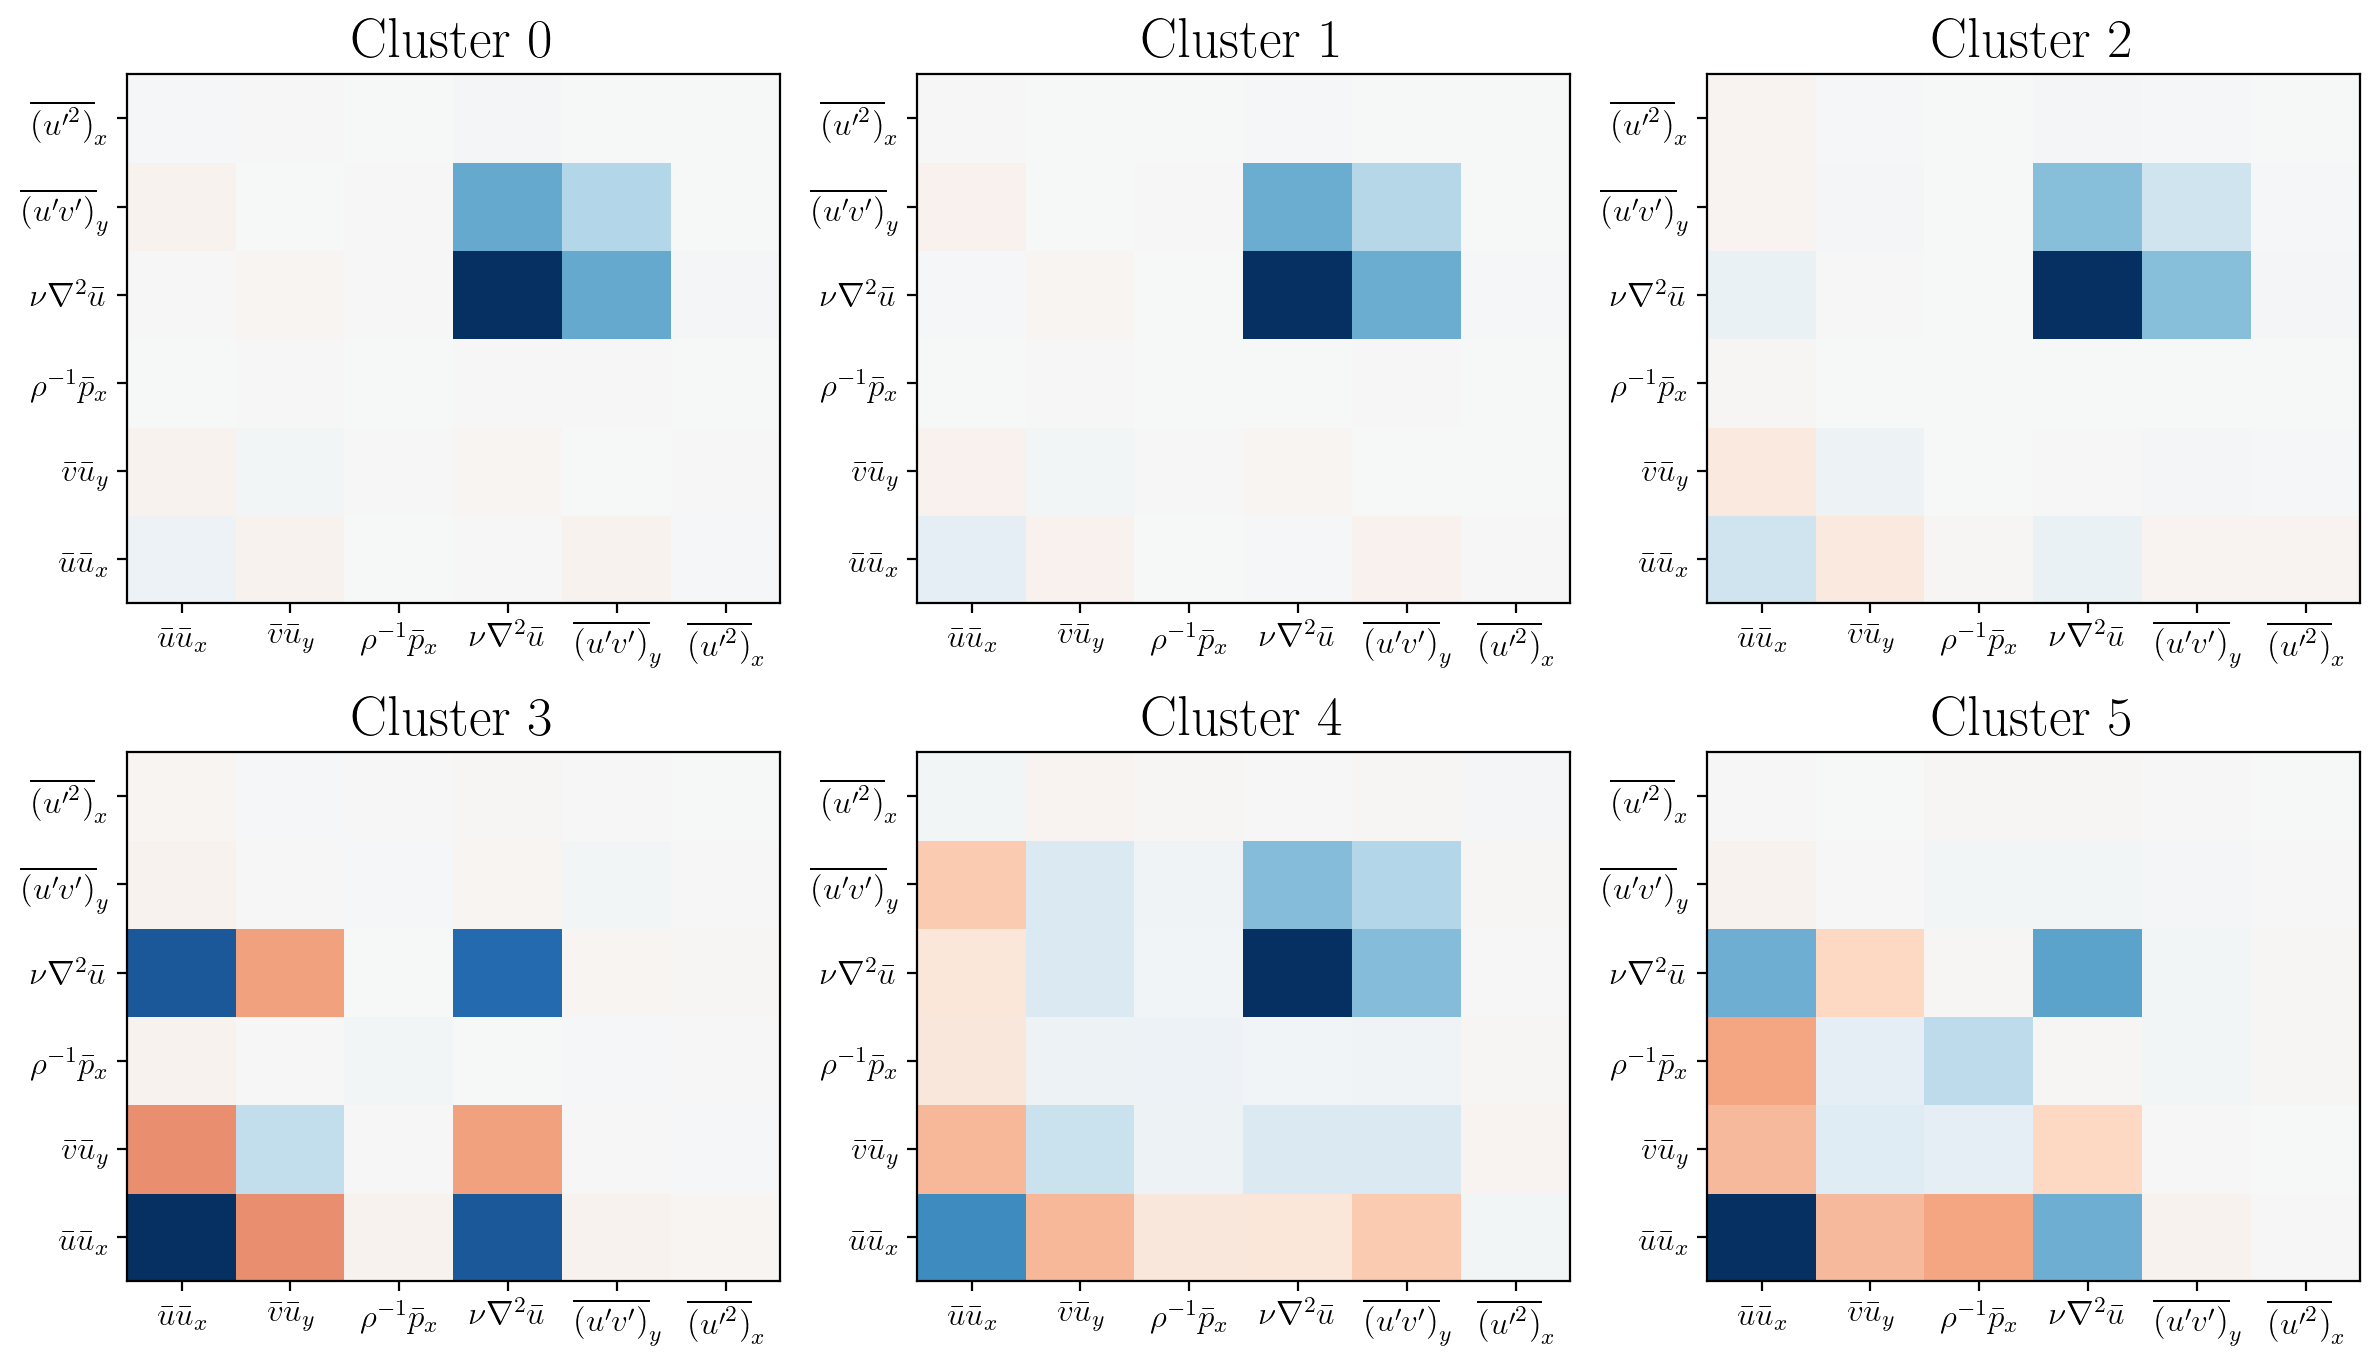

In [16]:
# Fit and predict the model
model.fit_predict(features_sc)

# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
features_mask = features_sc
for i in range(nc):
    mask_ = model.labels_ == i
    covs[i, :, :] = np.cov(features_mask[mask_, :].T)

# Plot the covariances
pf.plot_cov_mat(covs, nfeatures, nc, "Other")

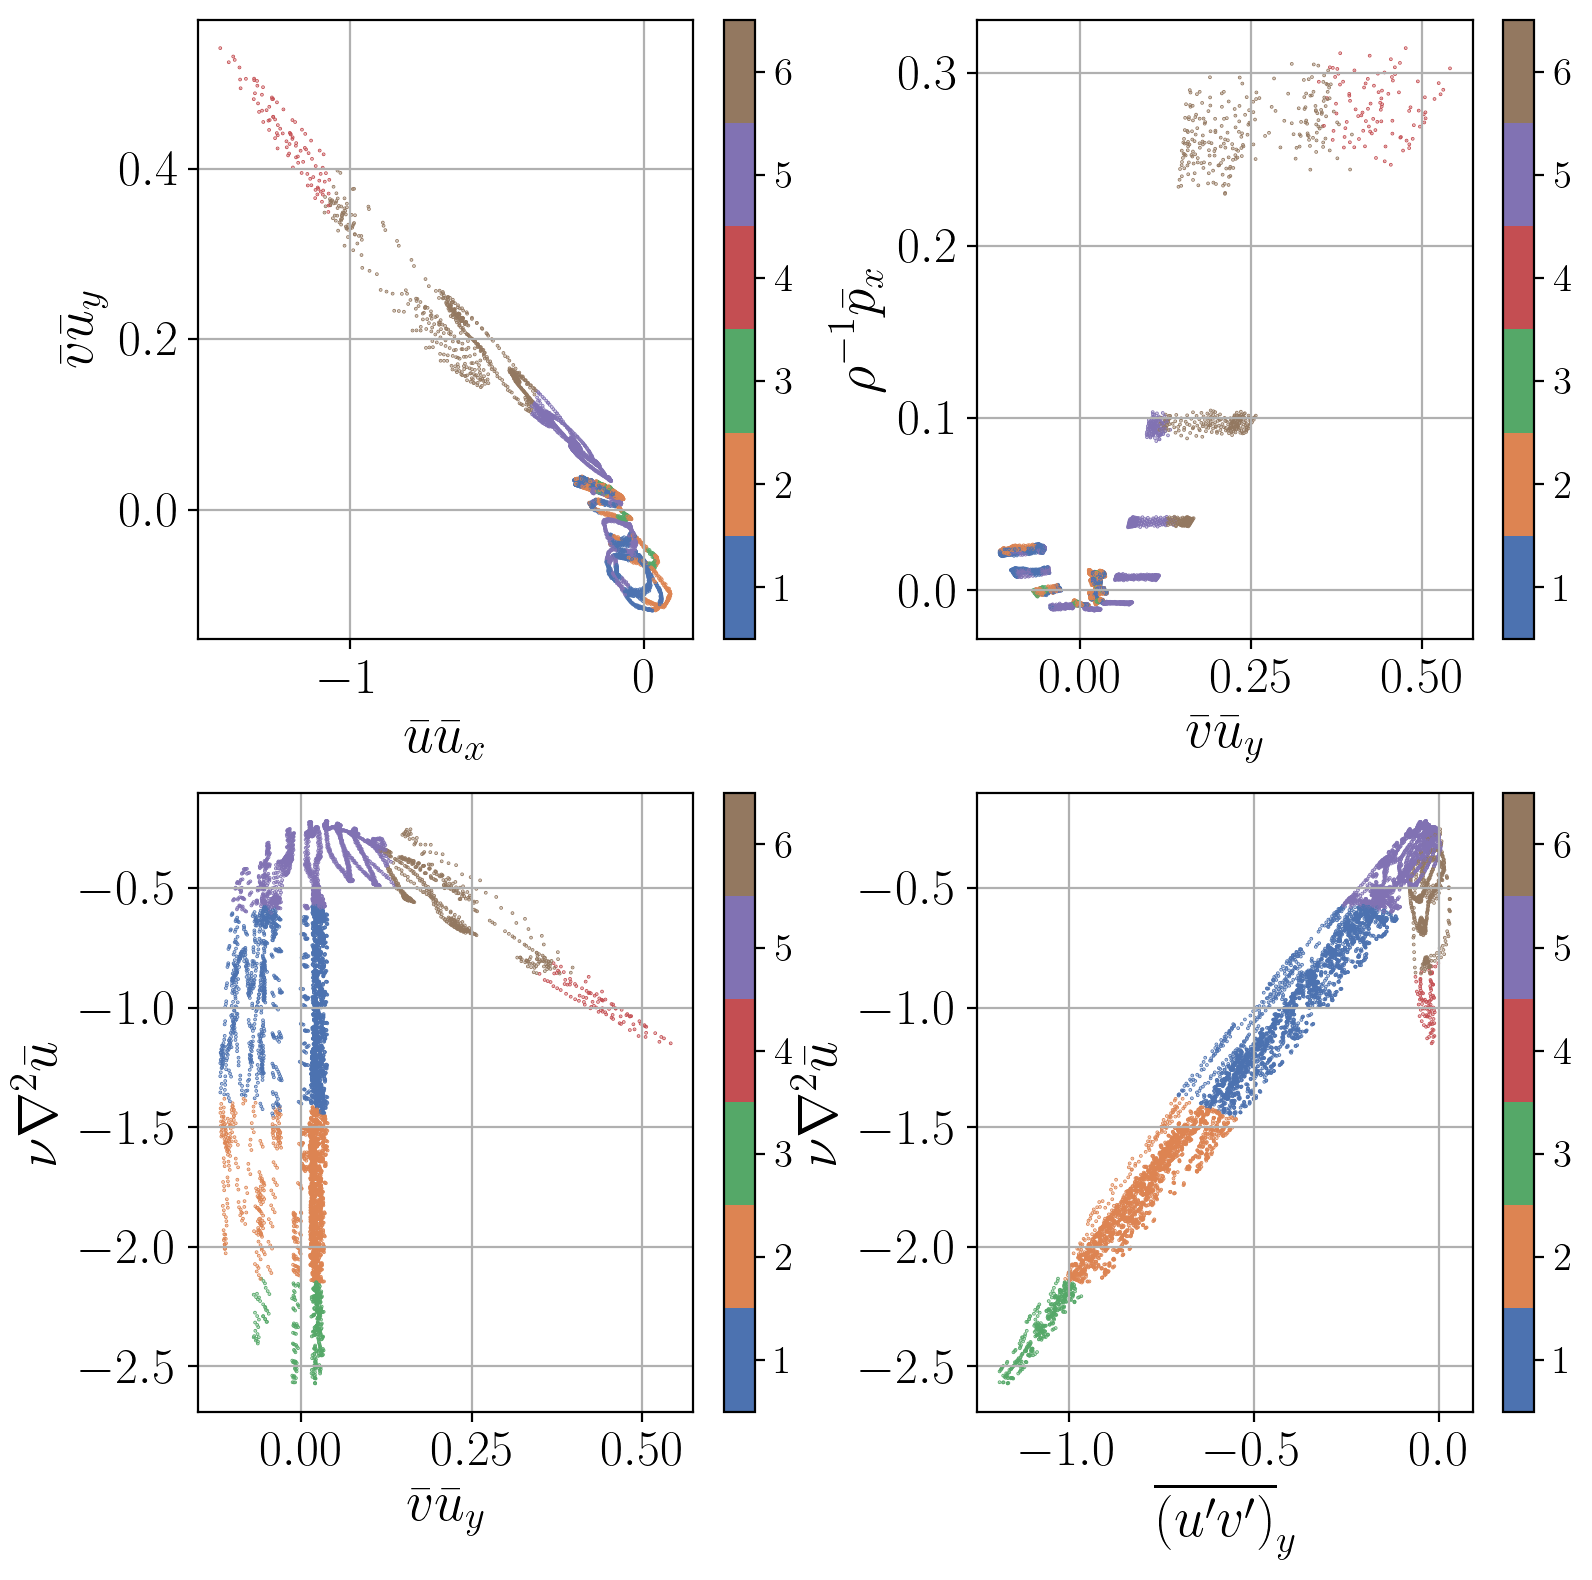

In [17]:
# Visualize GMM clustering with 2D views of equation space
cluster_idx = model.labels_ + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features_sc, cluster_idx, nc)

In [16]:
# Assign points in space to each cluster
cluster_idx = model.labels_

In [17]:
cluster_idx.shape

(8300,)

In [18]:
clustermap = np.reshape(cluster_idx, [ny_sc, nx_sc], order="F")

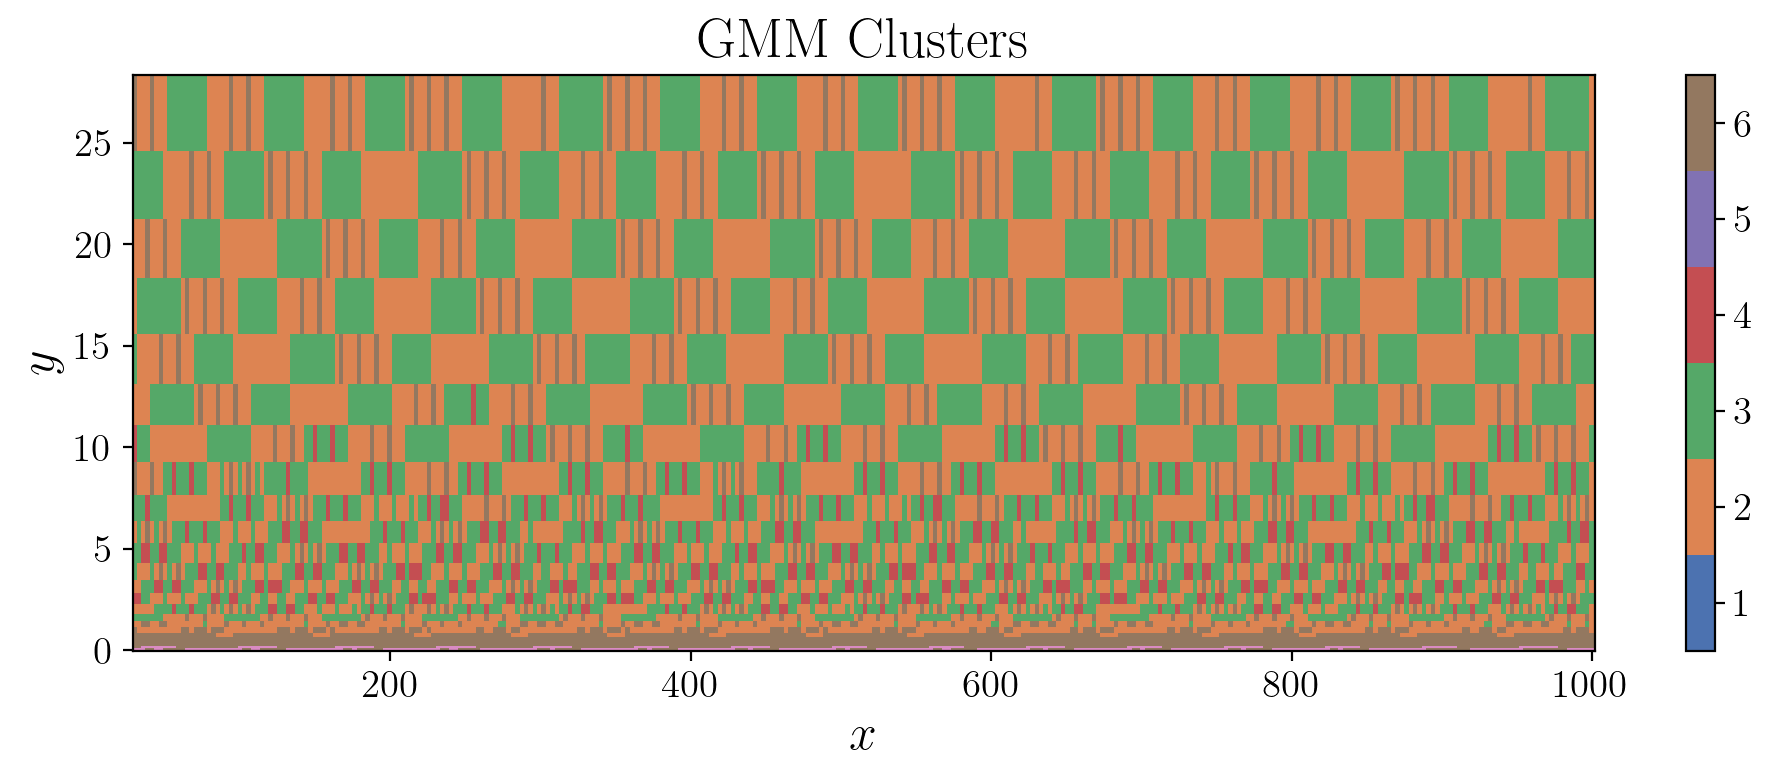

In [19]:
# Visualize the clustering in space
pf.plot_clustering_space(
    clustermap, x_sc, y_sc, X_sc, Y_sc, nx_sc, ny_sc, nc, u_sc, U_inf
)

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

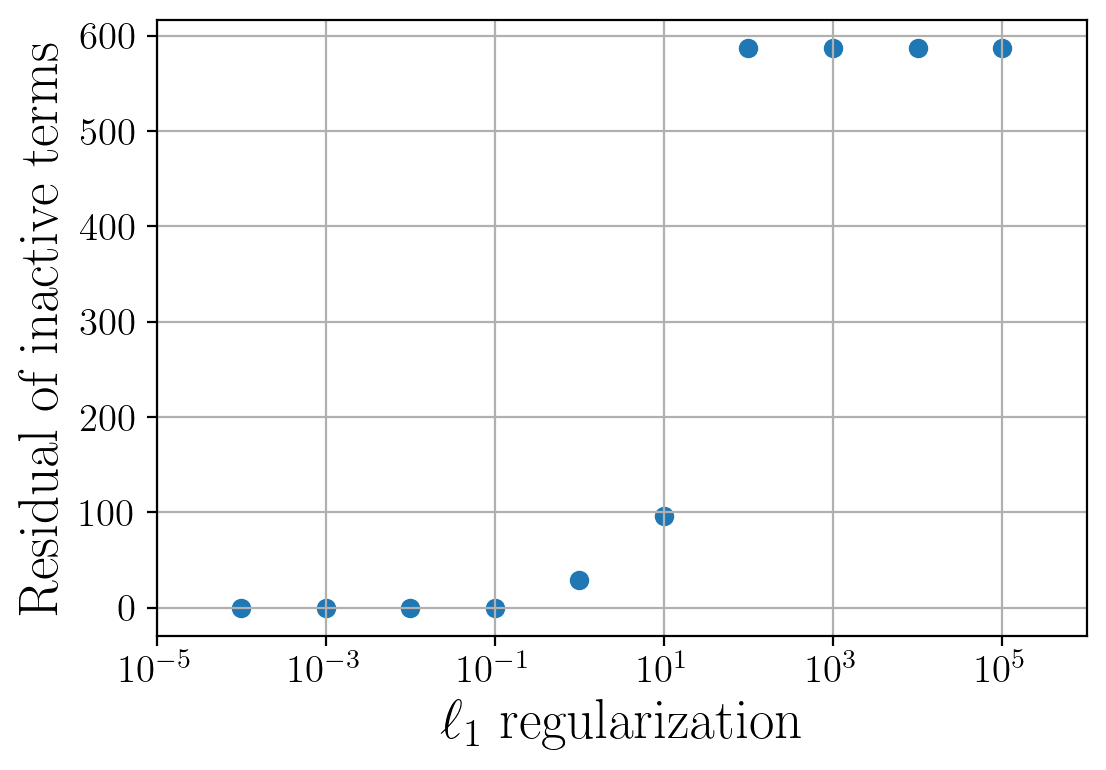

In [20]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alphas[k])  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

In [21]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 10  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
    spca.fit(cluster_features)

    print("GMM Cluster {0}:".format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set the active terms to 1
    else:
        print("None")

GMM Cluster 0:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 3:
None
GMM Cluster 4:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 5:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']


## c. Resulting Final Dominant Balance Models

In [22]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print balance models
for i in range(nmodels):
    print("SPCA Cluster {0}:".format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
    else:
        print("No dynamics")

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny_sc, nx_sc], order="F")

[[0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0.]]
SPCA Cluster 0:
No dynamics
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']


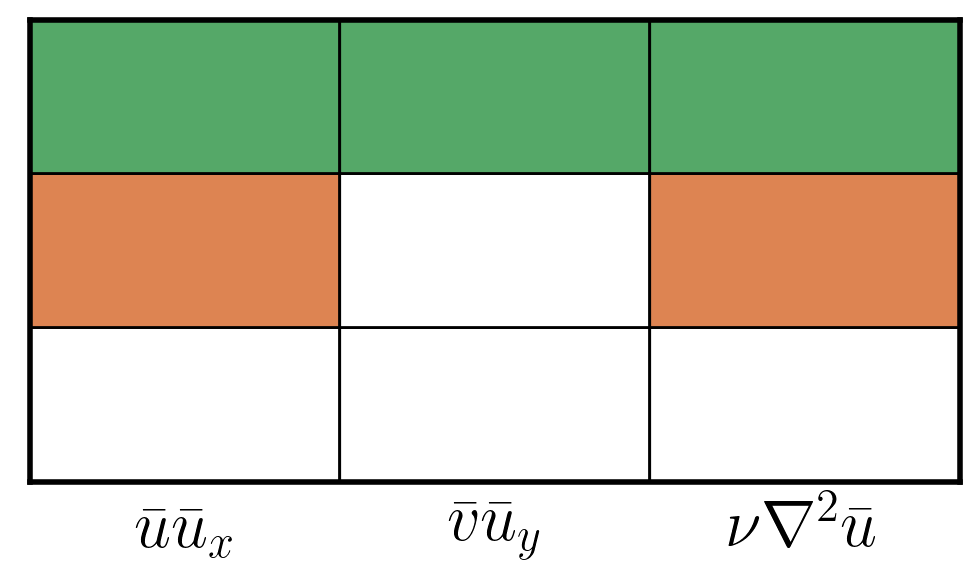

In [81]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (gridmap.T * np.arange(nmodels)).T + 1
gridmap[gridmask] = 0

# Delete unused terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

# 2. K-Means

In [13]:
from sklearn.cluster import KMeans

## a. Train the model and predict for full dataset

In [14]:
# Train K-means model

# Gather the terms into an array of features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# Fit Gaussian mixture model
nc = 6  # Number of clusters
seed = np.random.randint(2**32)
seed = 3696299933  #  Set a seed for debugging/plotting
model = KMeans(n_clusters=nc, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]

In [15]:
# Set tanh sample weights
model.fit(features[mask, :])

KMeans(n_clusters=6, random_state=3696299933)

In [16]:
# Predict clusters for all data
clustering = model.predict(features)

# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = clustering == i
    covs[i, :, :] = np.cov(features[mask_, :].T)

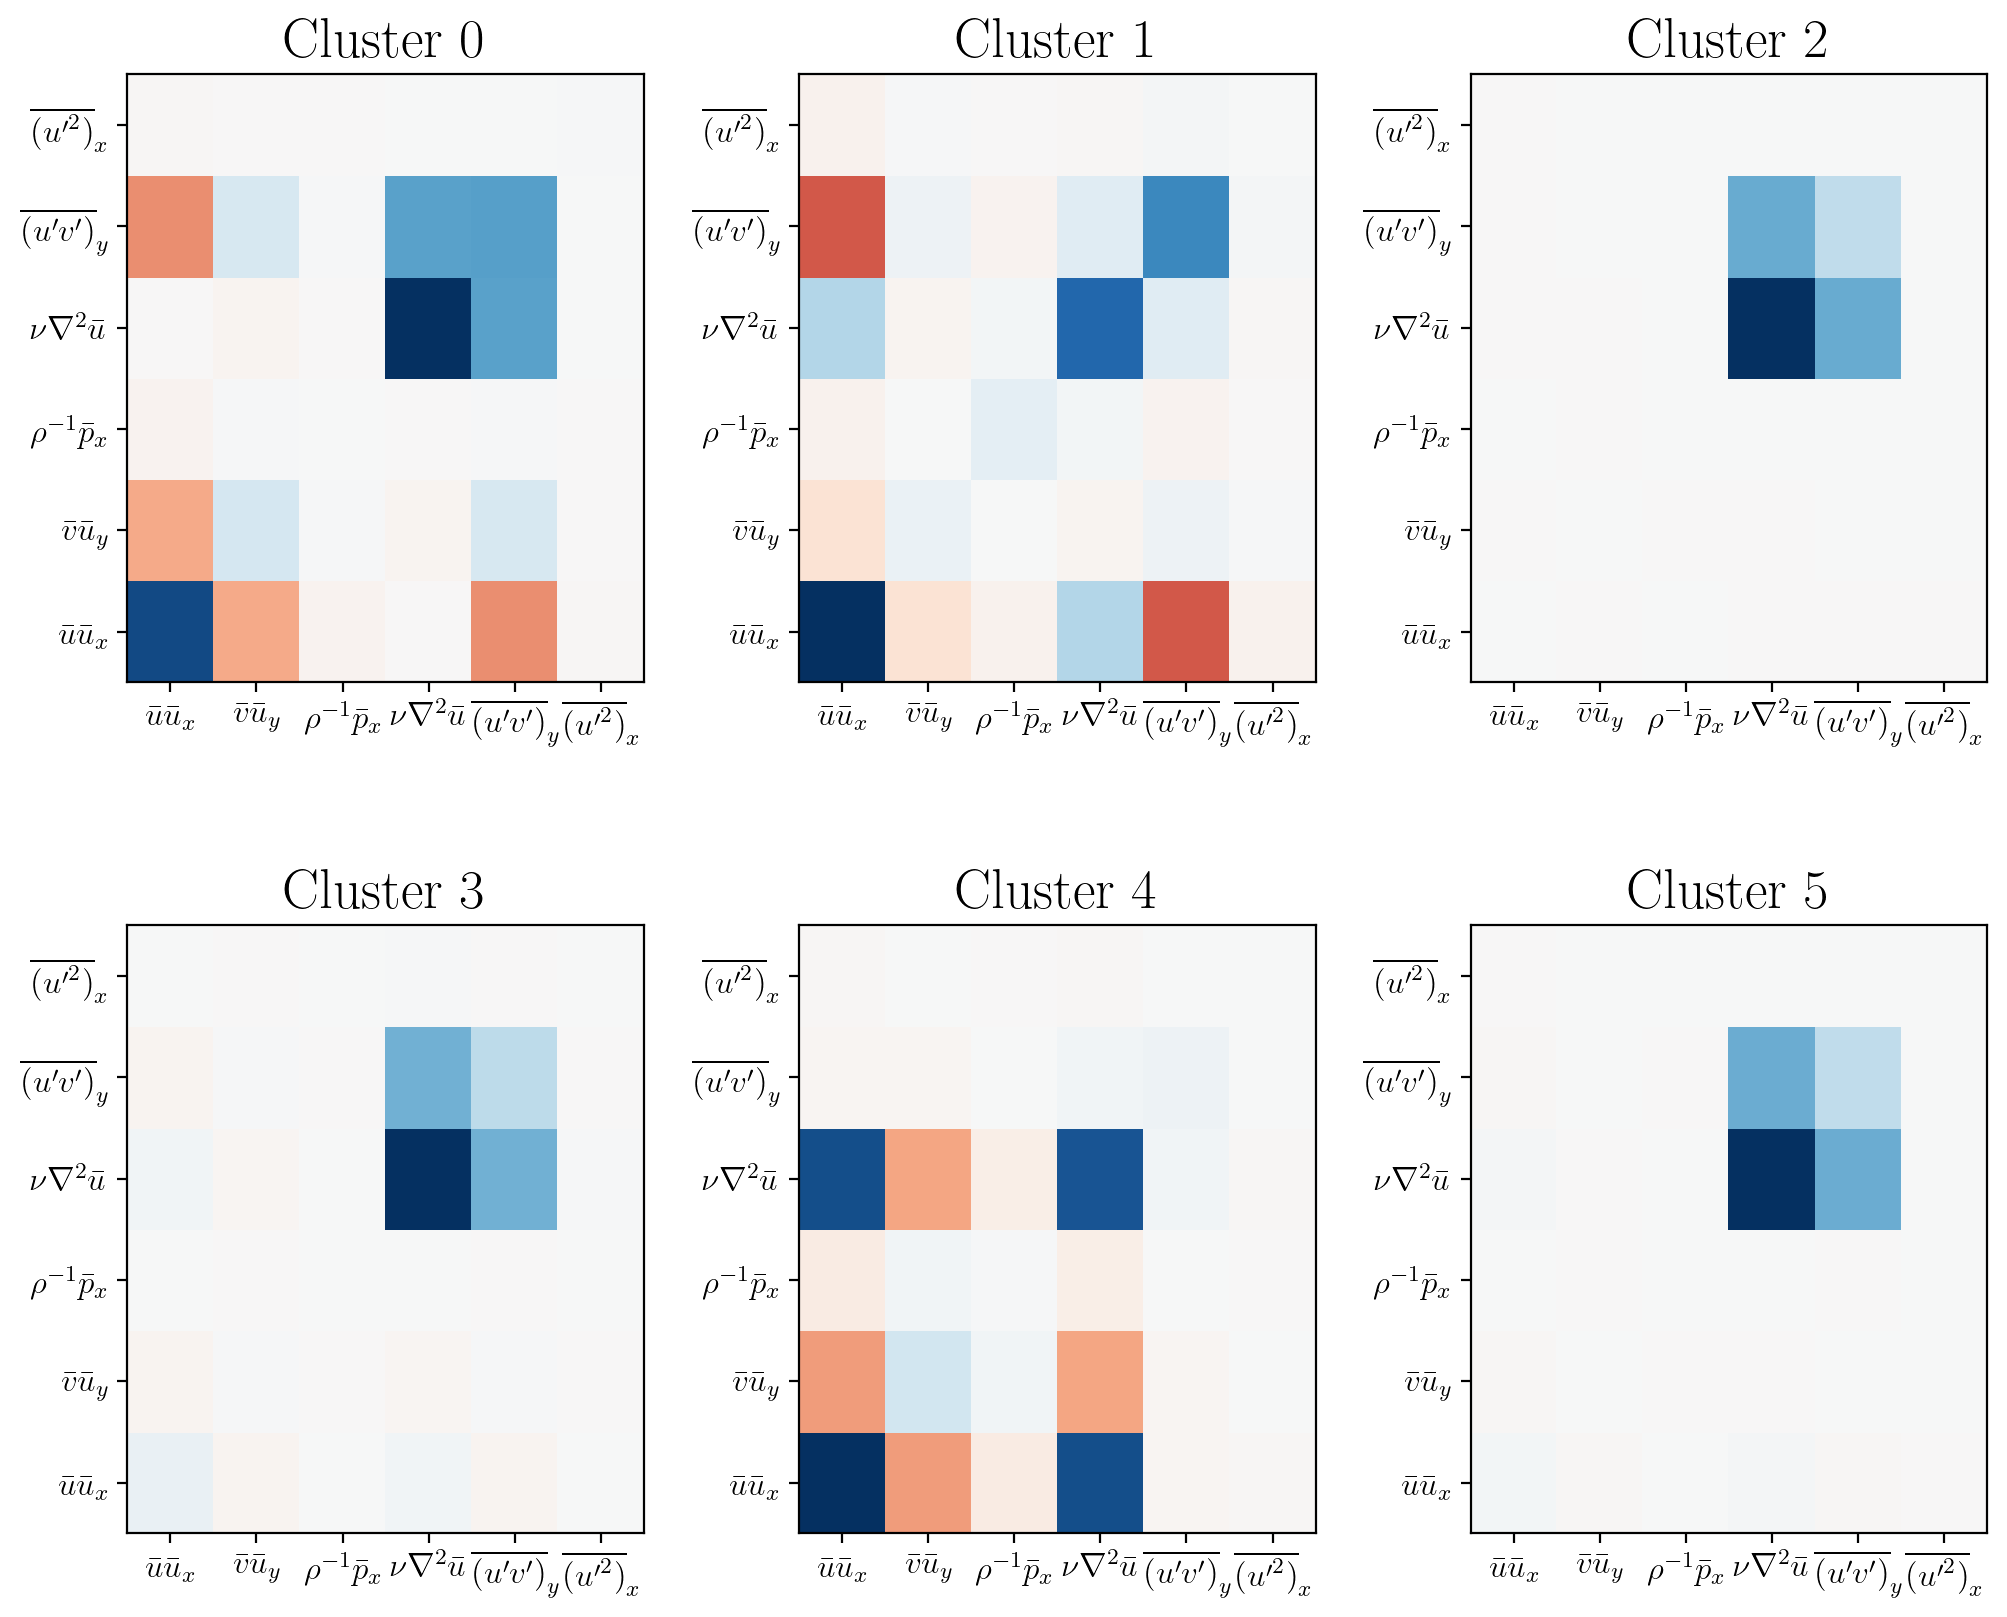

In [17]:
# Plot covariance matrices for each GMM cluster
pf.plot_cov_mat(covs, nfeatures, nc, "Other")

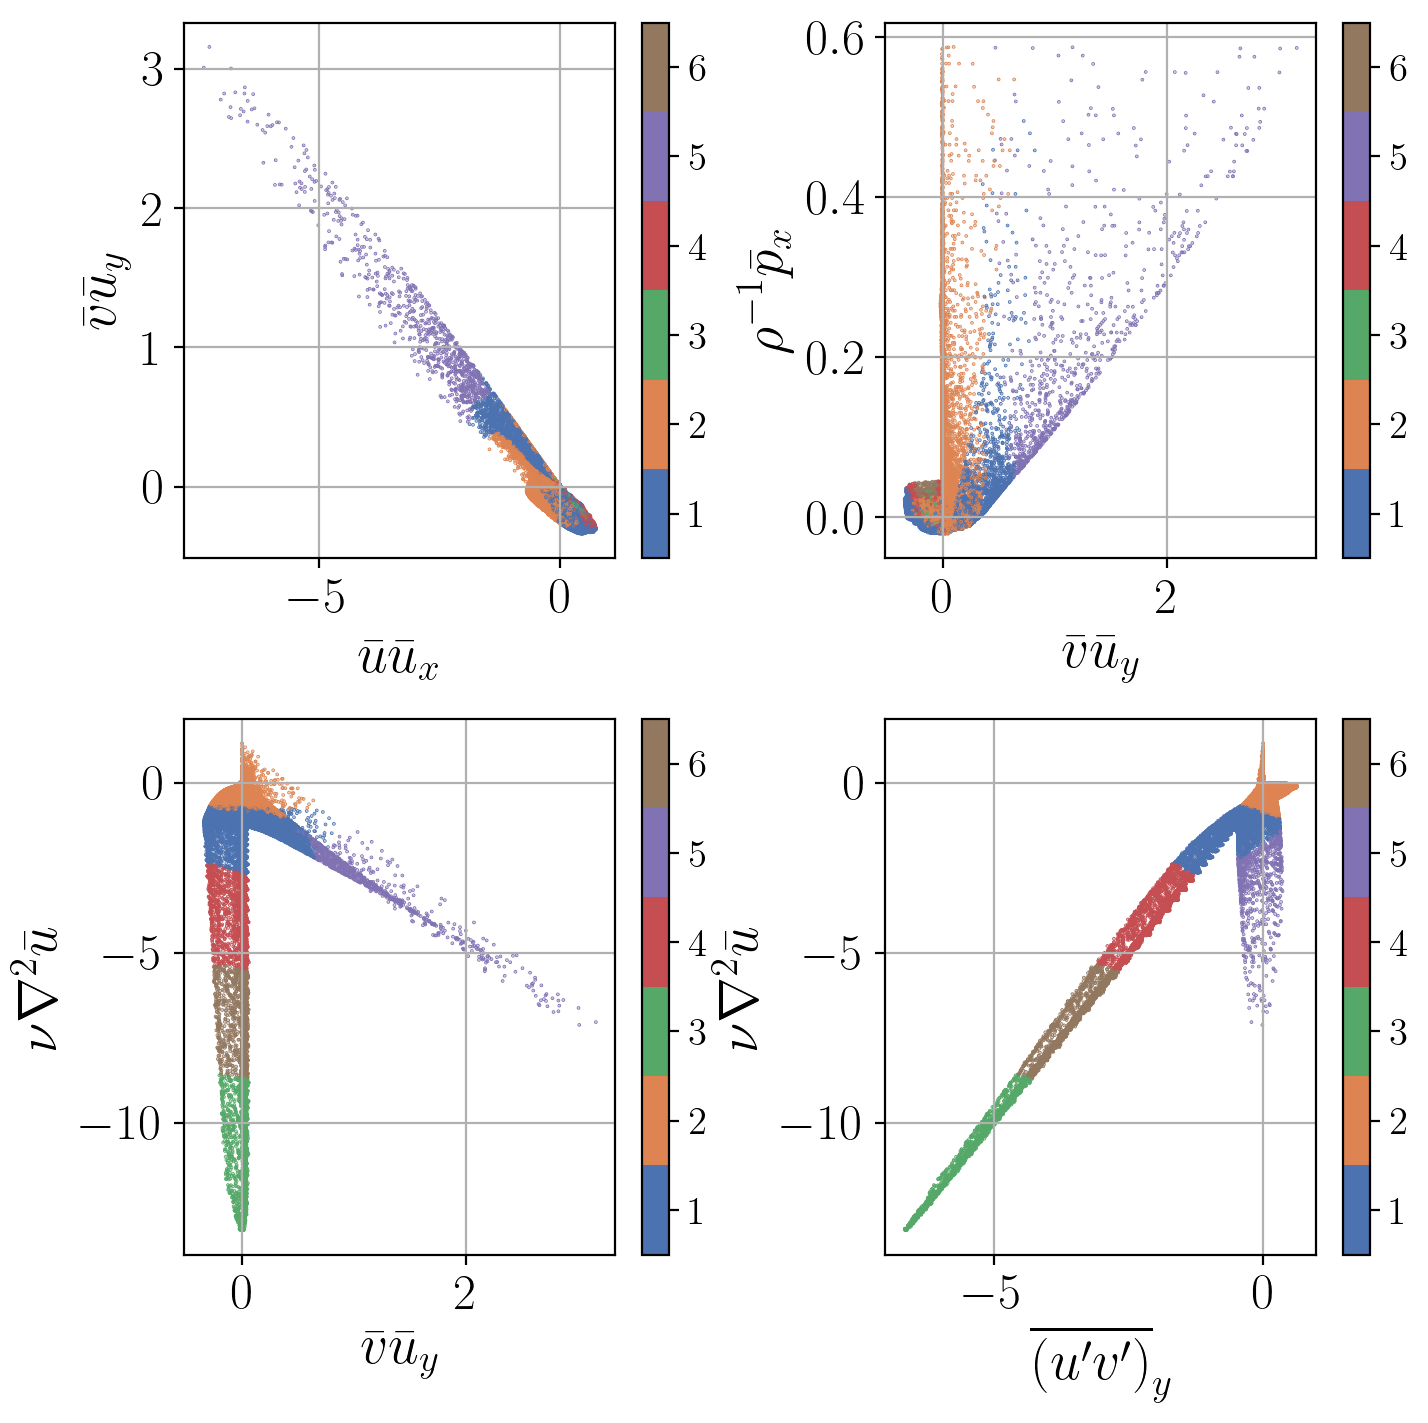

In [18]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features[mask, :]) + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features, cluster_idx, mask, nc)

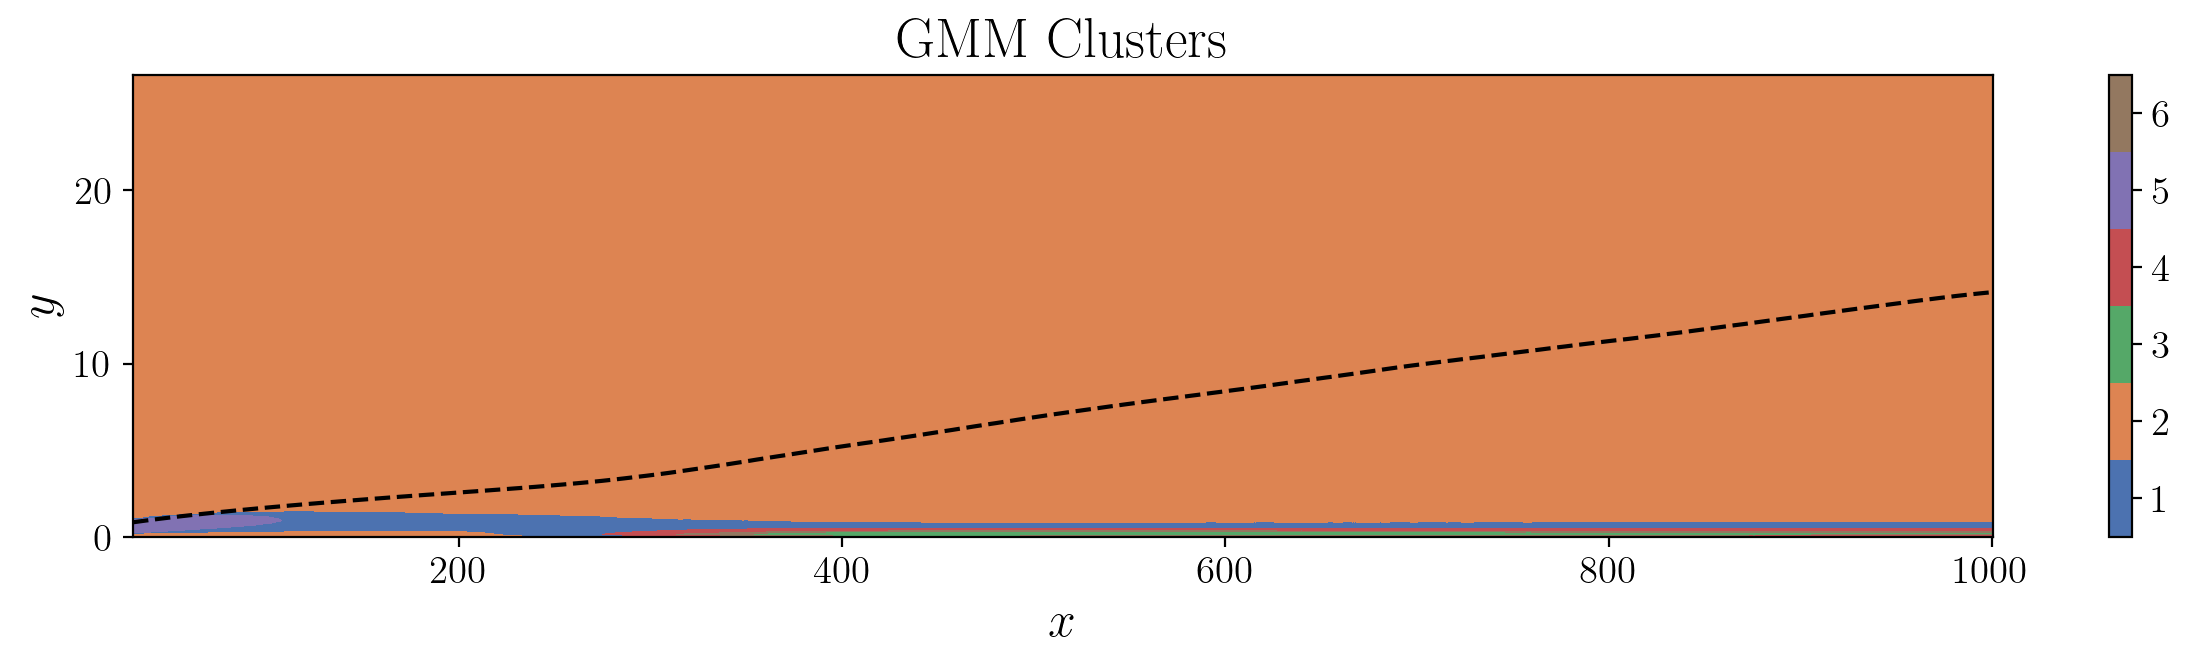

In [19]:
# Assign points in space to each cluster
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(clustermap, x, y, X, Y, nx, ny, nc, u, U_inf)

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

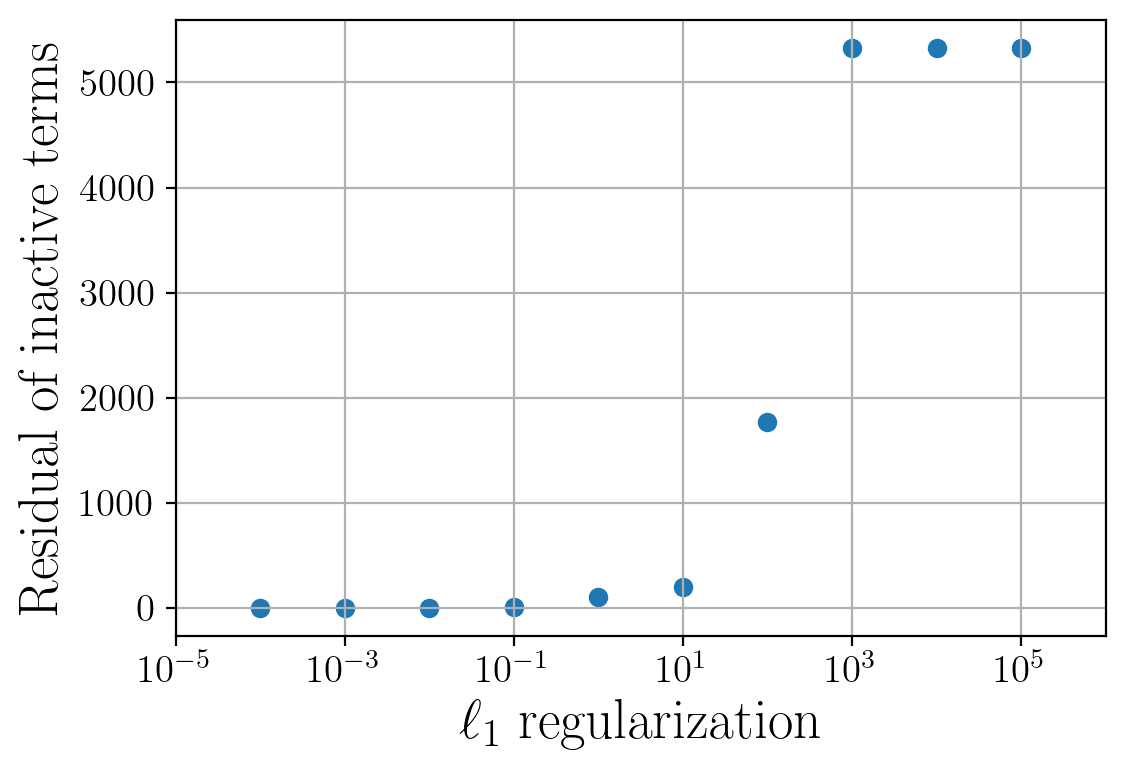

In [20]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alphas[k])  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

In [21]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 10  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
    spca.fit(cluster_features)

    print("GMM Cluster {0}:".format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set the active terms to 1
    else:
        print("None")

GMM Cluster 0:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 2:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 3:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 4:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 5:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


## c. Resulting Final Dominant Balance Models

In [22]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print balance models
for i in range(nmodels):
    print("SPCA Cluster {0}:".format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
    else:
        print("No dynamics")

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

[[0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1. 0.]]
SPCA Cluster 0:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$']
SPCA Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


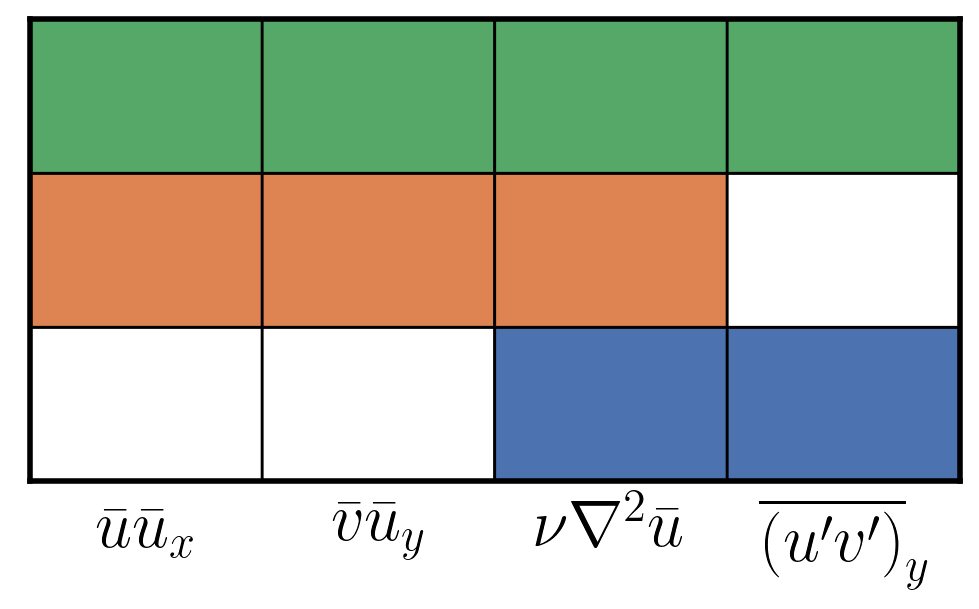

In [23]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (
    gridmap.T * np.arange(nmodels)
).T + 1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

# Delete zero terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

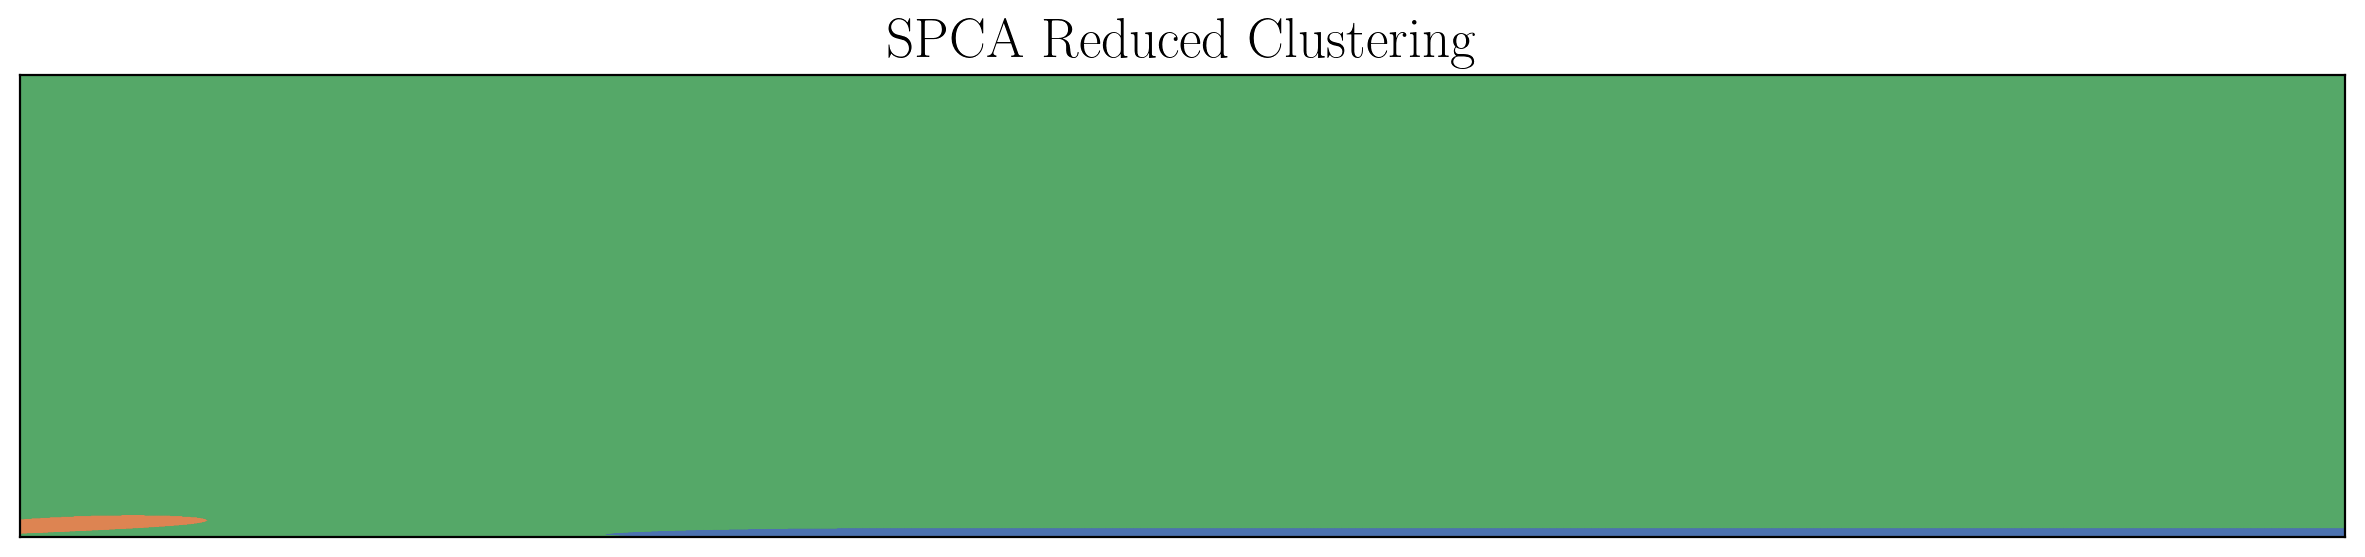

In [24]:
pf.plot_spca_reduced_clustering(x, y, balancemap)

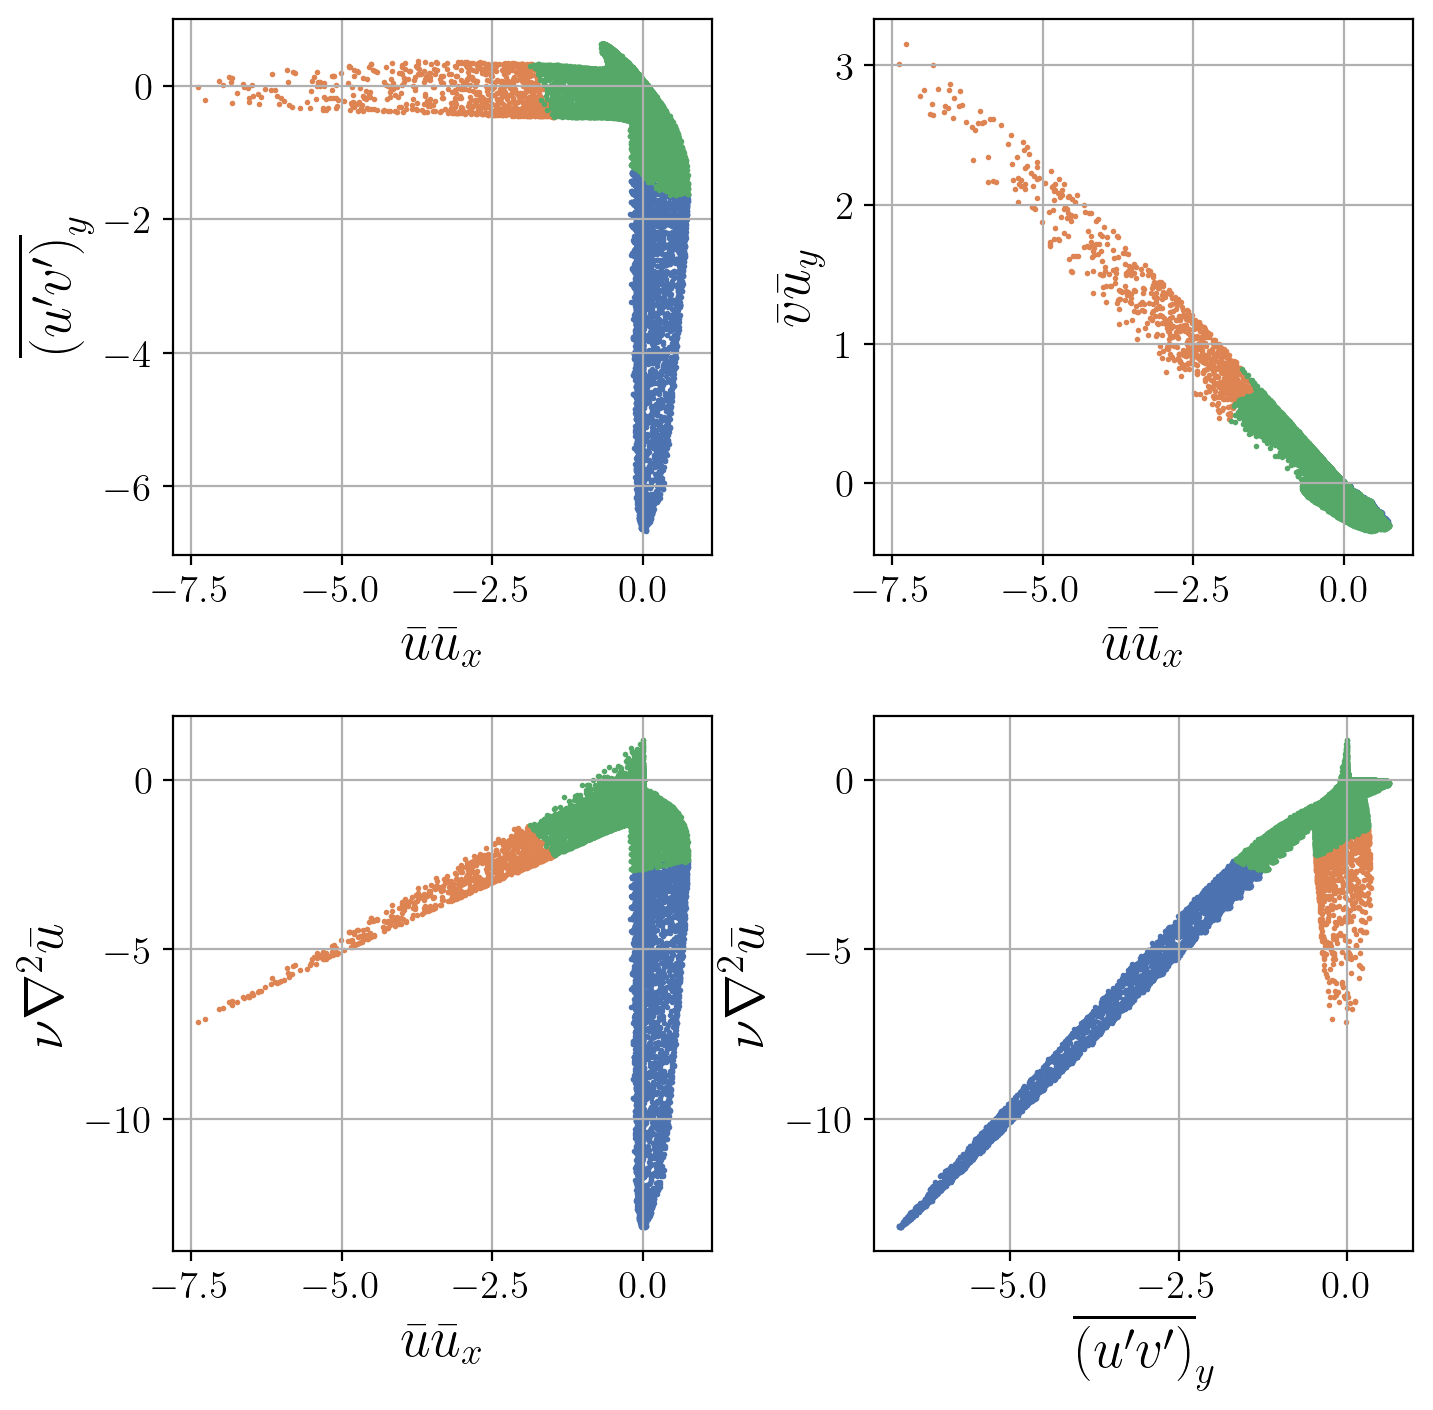

In [25]:
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nmodels + 1.5)
fontsize = 20
s = 1

# Plot order of the terms for best visibility
order = [3, 0, 4, 1, 2]

# 2D views of feature space
pf.plot_feature_space(features, mask, balance_idx)

# 3. Weighted K-Means 

In [23]:
from sklearn.cluster import KMeans

## a. Train the model and predict for full dataset

In [24]:
# Train K-means model

# Gather the terms into an array of features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# Fit Gaussian mixture model
nc = 6  # Number of clusters
seed = np.random.randint(2**32)
seed = 3696299933  #  Set a seed for debugging/plotting
model = KMeans(n_clusters=nc, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]

In [25]:
# Set tanh sample weights
origin_dist_mask = np.linalg.norm(features[mask, :], axis=1)
sample_weights_mask = 1 - (np.tanh((1 / 2) * origin_dist_mask)) ** 2
model.fit(features[mask, :], sample_weight=sample_weights_mask)

KMeans(n_clusters=6, random_state=3696299933)

In [26]:
# Predict clusters for all data
origin_dist = np.linalg.norm(features, axis=1)
sample_weights = 1 - (np.tanh((1 / 2) * origin_dist)) ** 2
clustering = model.predict(features, sample_weight=sample_weights)

# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = clustering == i
    covs[i, :, :] = np.cov(features[mask_, :].T)

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1102: FutureWarning: 'sample_weight' was deprecated in version 1.3 and will be removed in 1.5.
  warnings.warn(


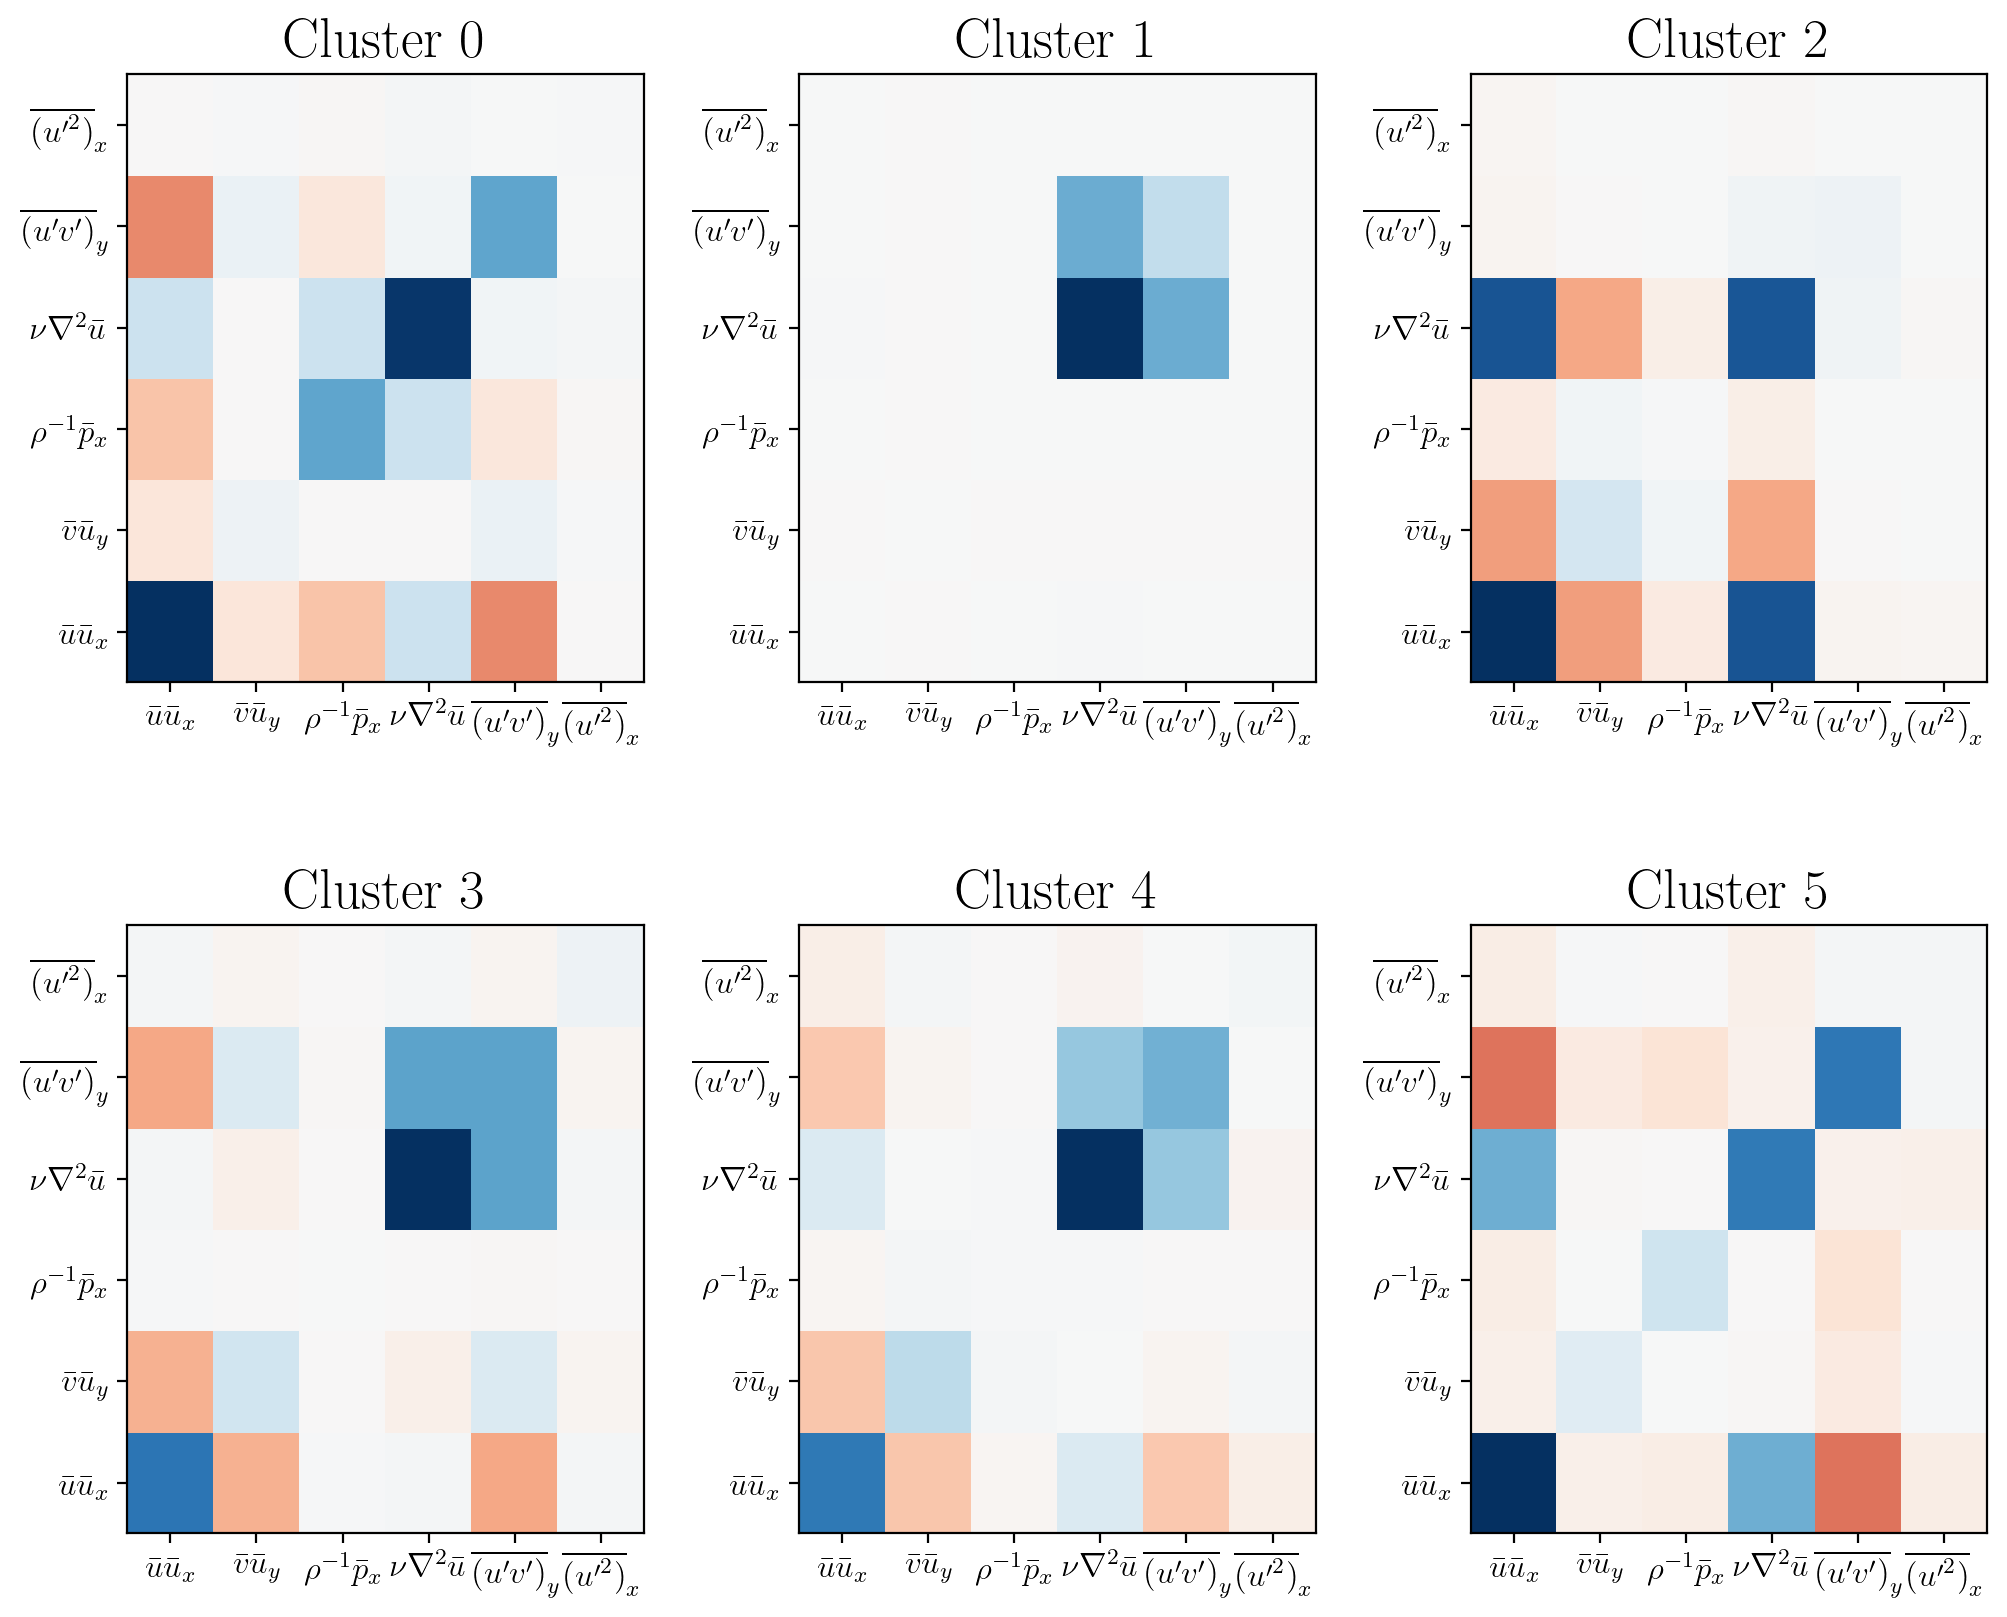

In [27]:
# Plot covariance matrices for each GMM cluster
pf.plot_cov_mat(covs, nfeatures, nc, "Other")

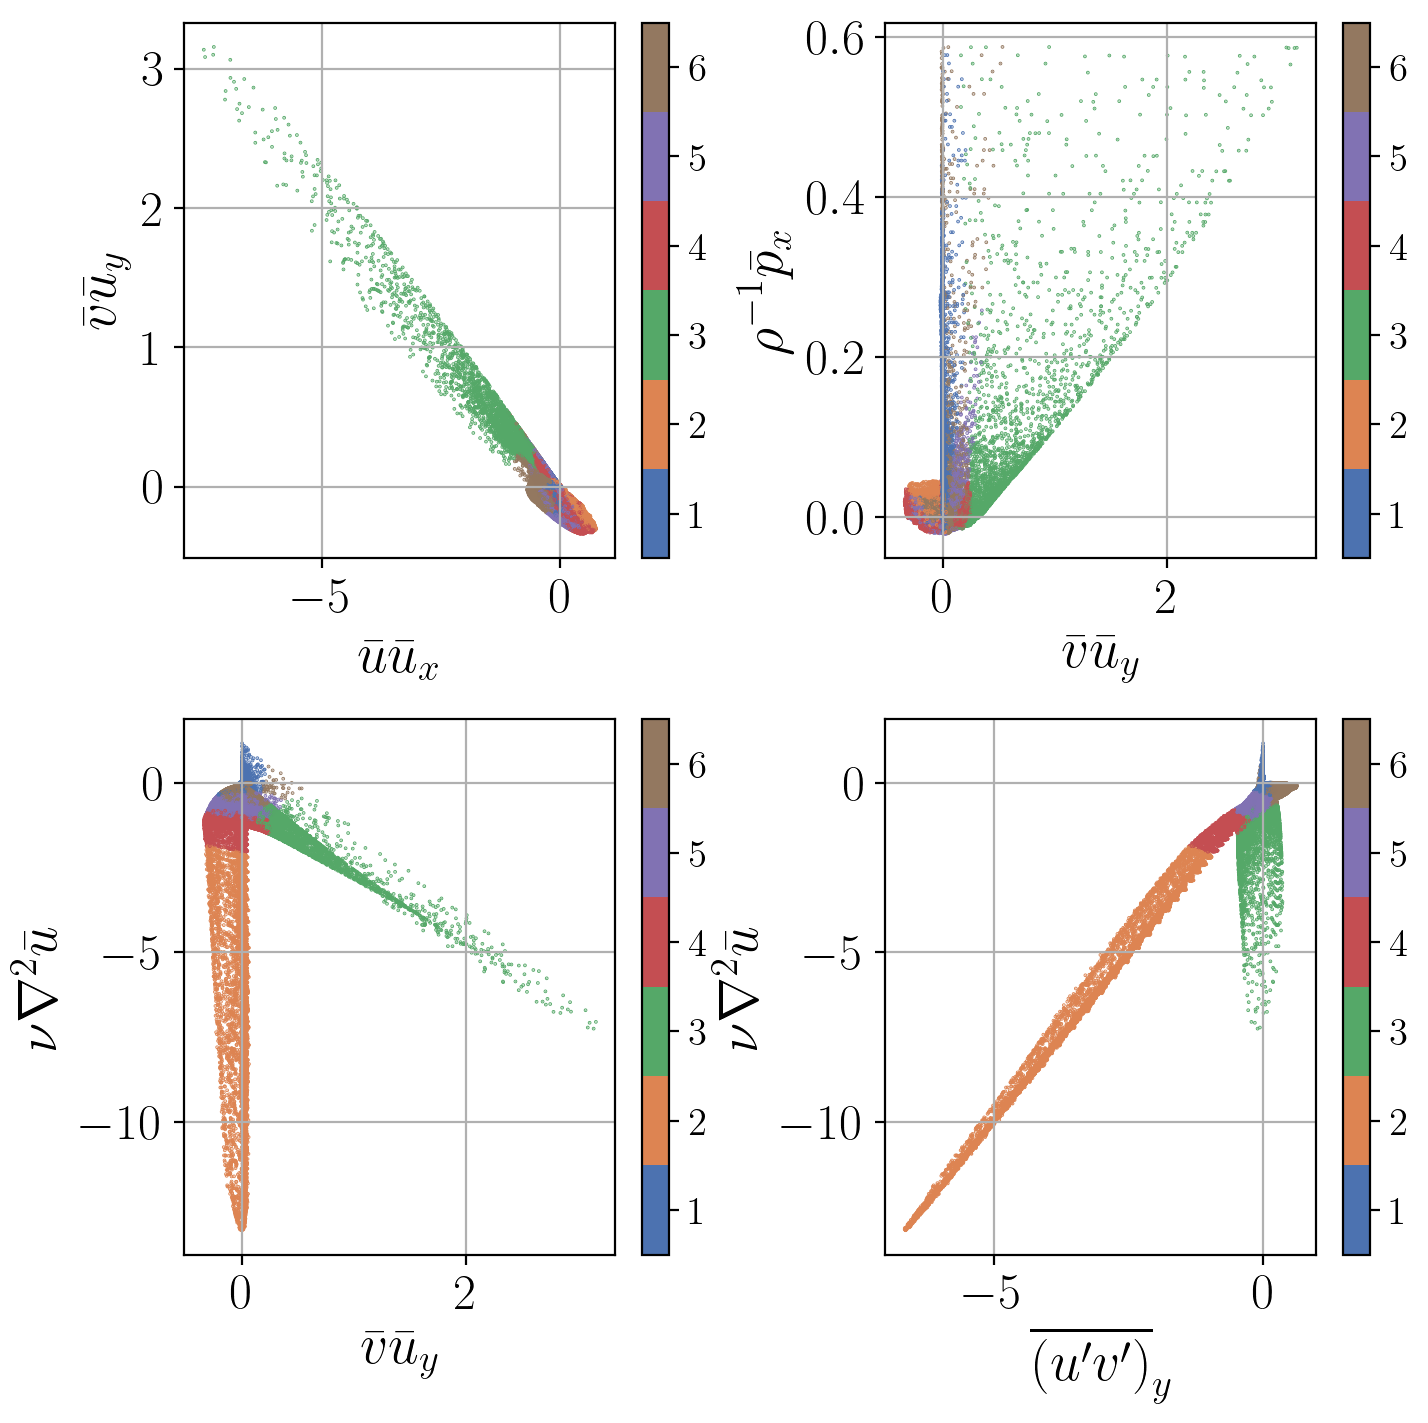

In [28]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features[mask, :]) + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features[mask, :], cluster_idx, nc)

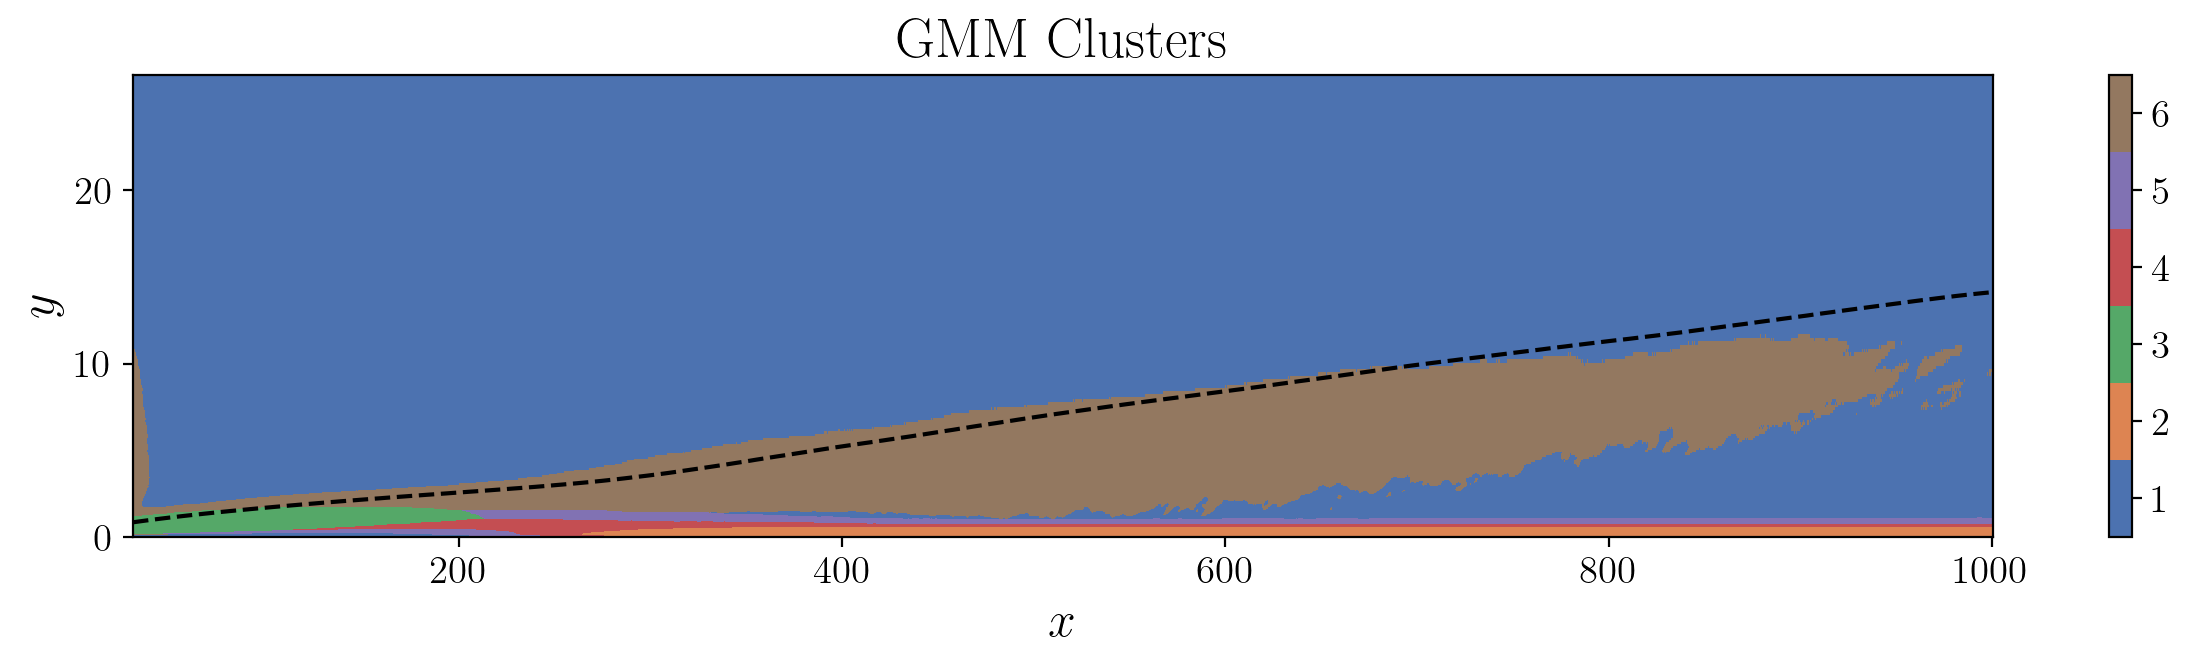

In [29]:
# Assign points in space to each cluster
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(clustermap, x, y, X, Y, nx, ny, nc, u, U_inf)

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

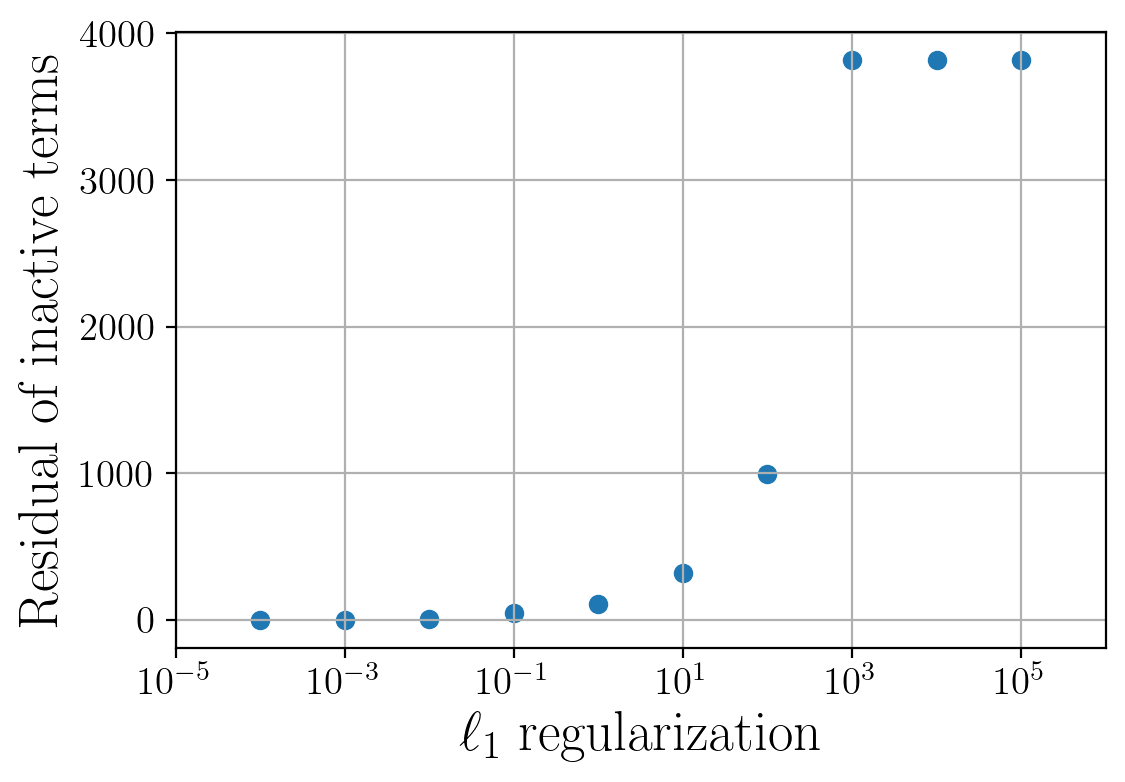

In [30]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alphas[k])  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

In [31]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 10  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
    spca.fit(cluster_features)

    print("GMM Cluster {0}:".format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set the active terms to 1
    else:
        print("None")

GMM Cluster 0:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 1:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\rho^{-1} \\bar{p}_x$', '$\\nu \\nabla^2 \\bar{u}$']
GMM Cluster 3:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 4:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 5:
['$\\bar{u} \\bar{u}_x$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


## c. Resulting Final Dominant Balance Models

In [32]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print balance models
for i in range(nmodels):
    print("SPCA Cluster {0}:".format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
    else:
        print("No dynamics")

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

[[0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 1. 1. 1. 0. 0.]]
SPCA Cluster 0:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\rho^{-1} \\bar{p}_x$', '$\\nu \\nabla^2 \\bar{u}$']


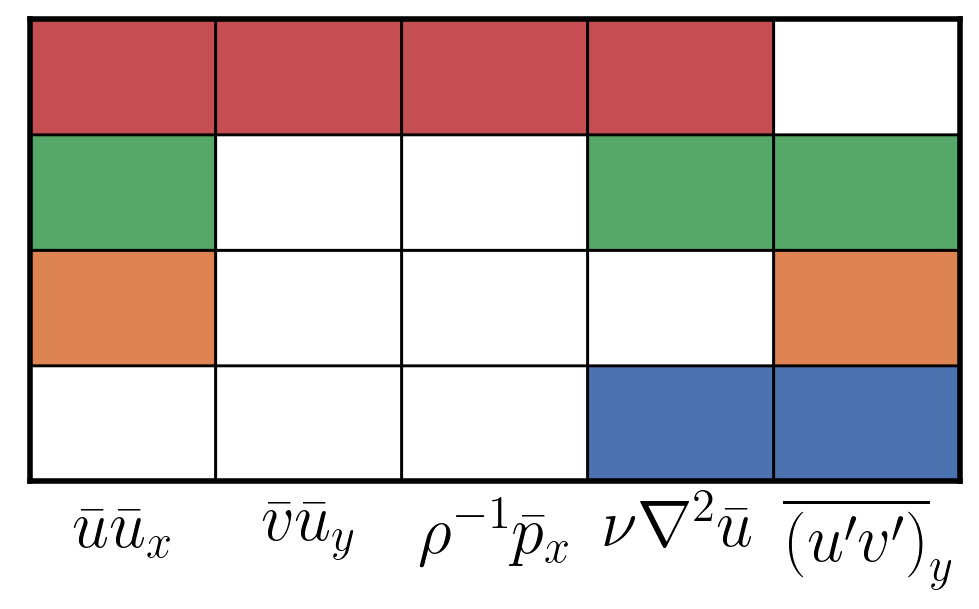

In [33]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (
    gridmap.T * np.arange(nmodels)
).T + 1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

# Delete zero terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

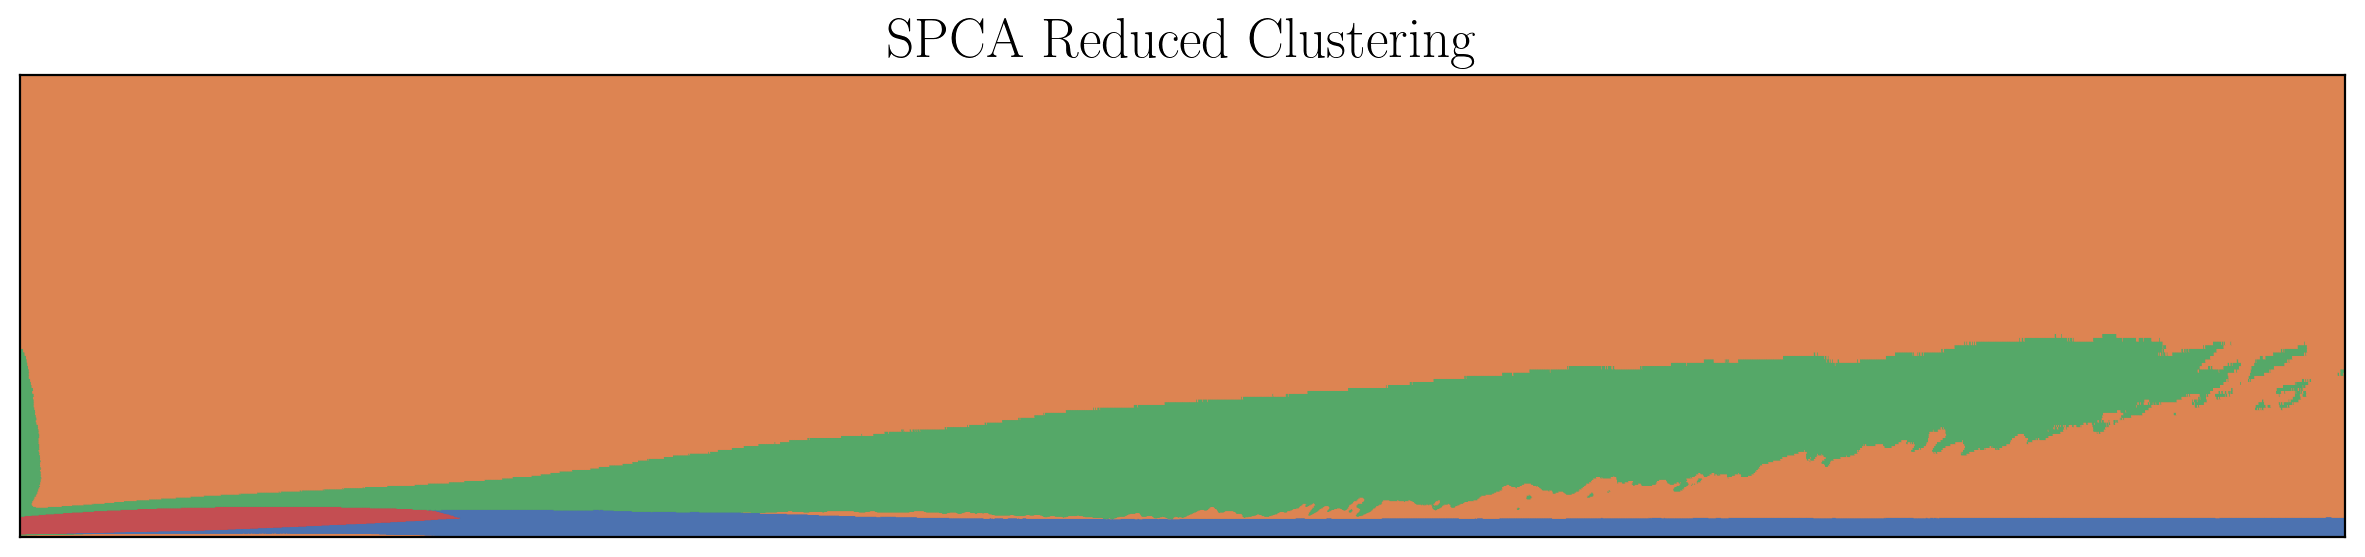

In [34]:
pf.plot_spca_reduced_clustering(x, y, balancemap)

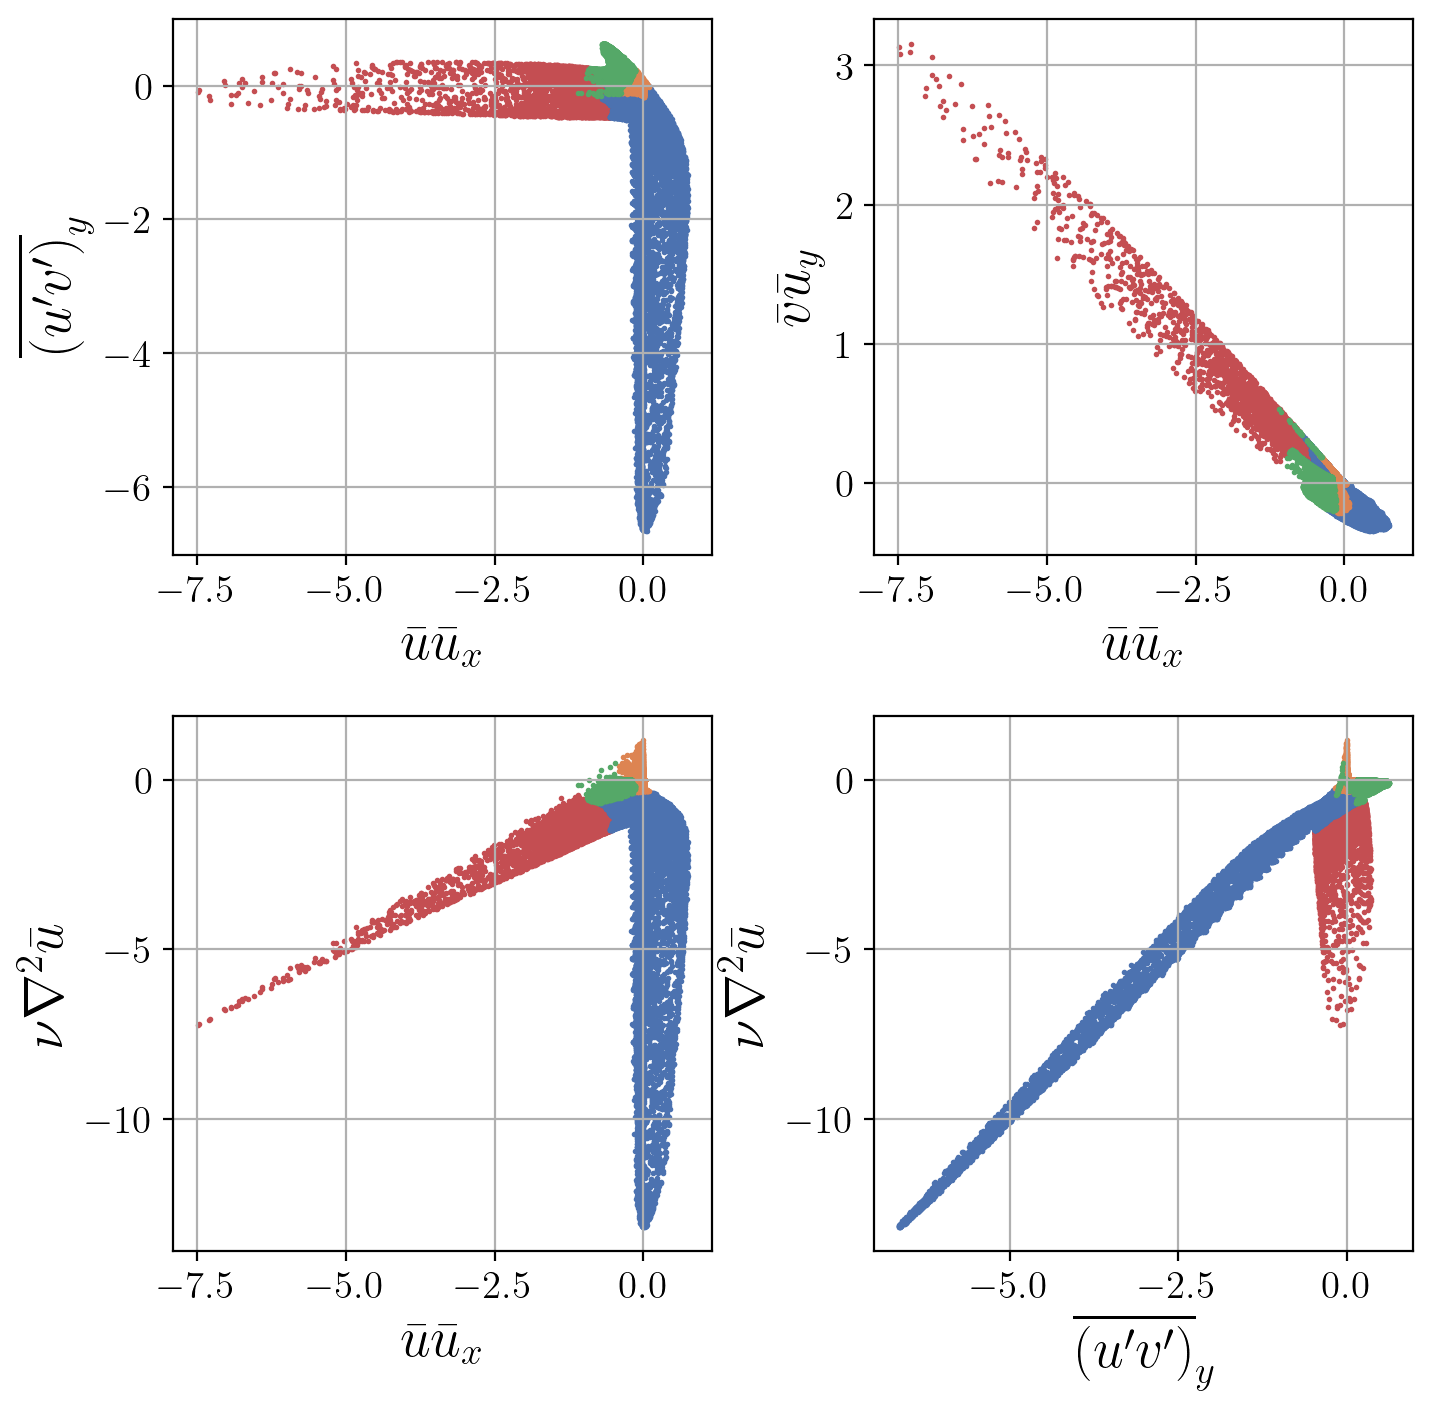

In [36]:
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nmodels + 1.5)
fontsize = 20
s = 1

# Plot order of the terms for best visibility
order = [3, 0, 4, 1, 2]

# 2D views of feature space
pf.plot_feature_space(features[mask, :], balance_idx[mask])

# 4. Bayesian Gaussian Mixture Model

## a. Train model and predict for full data

In [ ]:
# Train Gaussian mixture model
from sklearn.mixture import BayesianGaussianMixture

# Gather the terms into an array of features
features = 1e3 * np.vstack([u * ux, v * uy, px, nu * lap_u, Ruvy, Ruux]).T
nfeatures = features.shape[1]

# Fit Gaussian mixture model
nc = 6  # Number of clusters
seed = np.random.randint(2**32)
seed = 3696299933  #  Set a seed for debugging/plotting
model = BayesianGaussianMixture(n_components=nc, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]
model.fit(features[mask, :])

/Users/thomasbreitburd/anaconda3/envs/Project_24/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=6, random_state=3696299933)

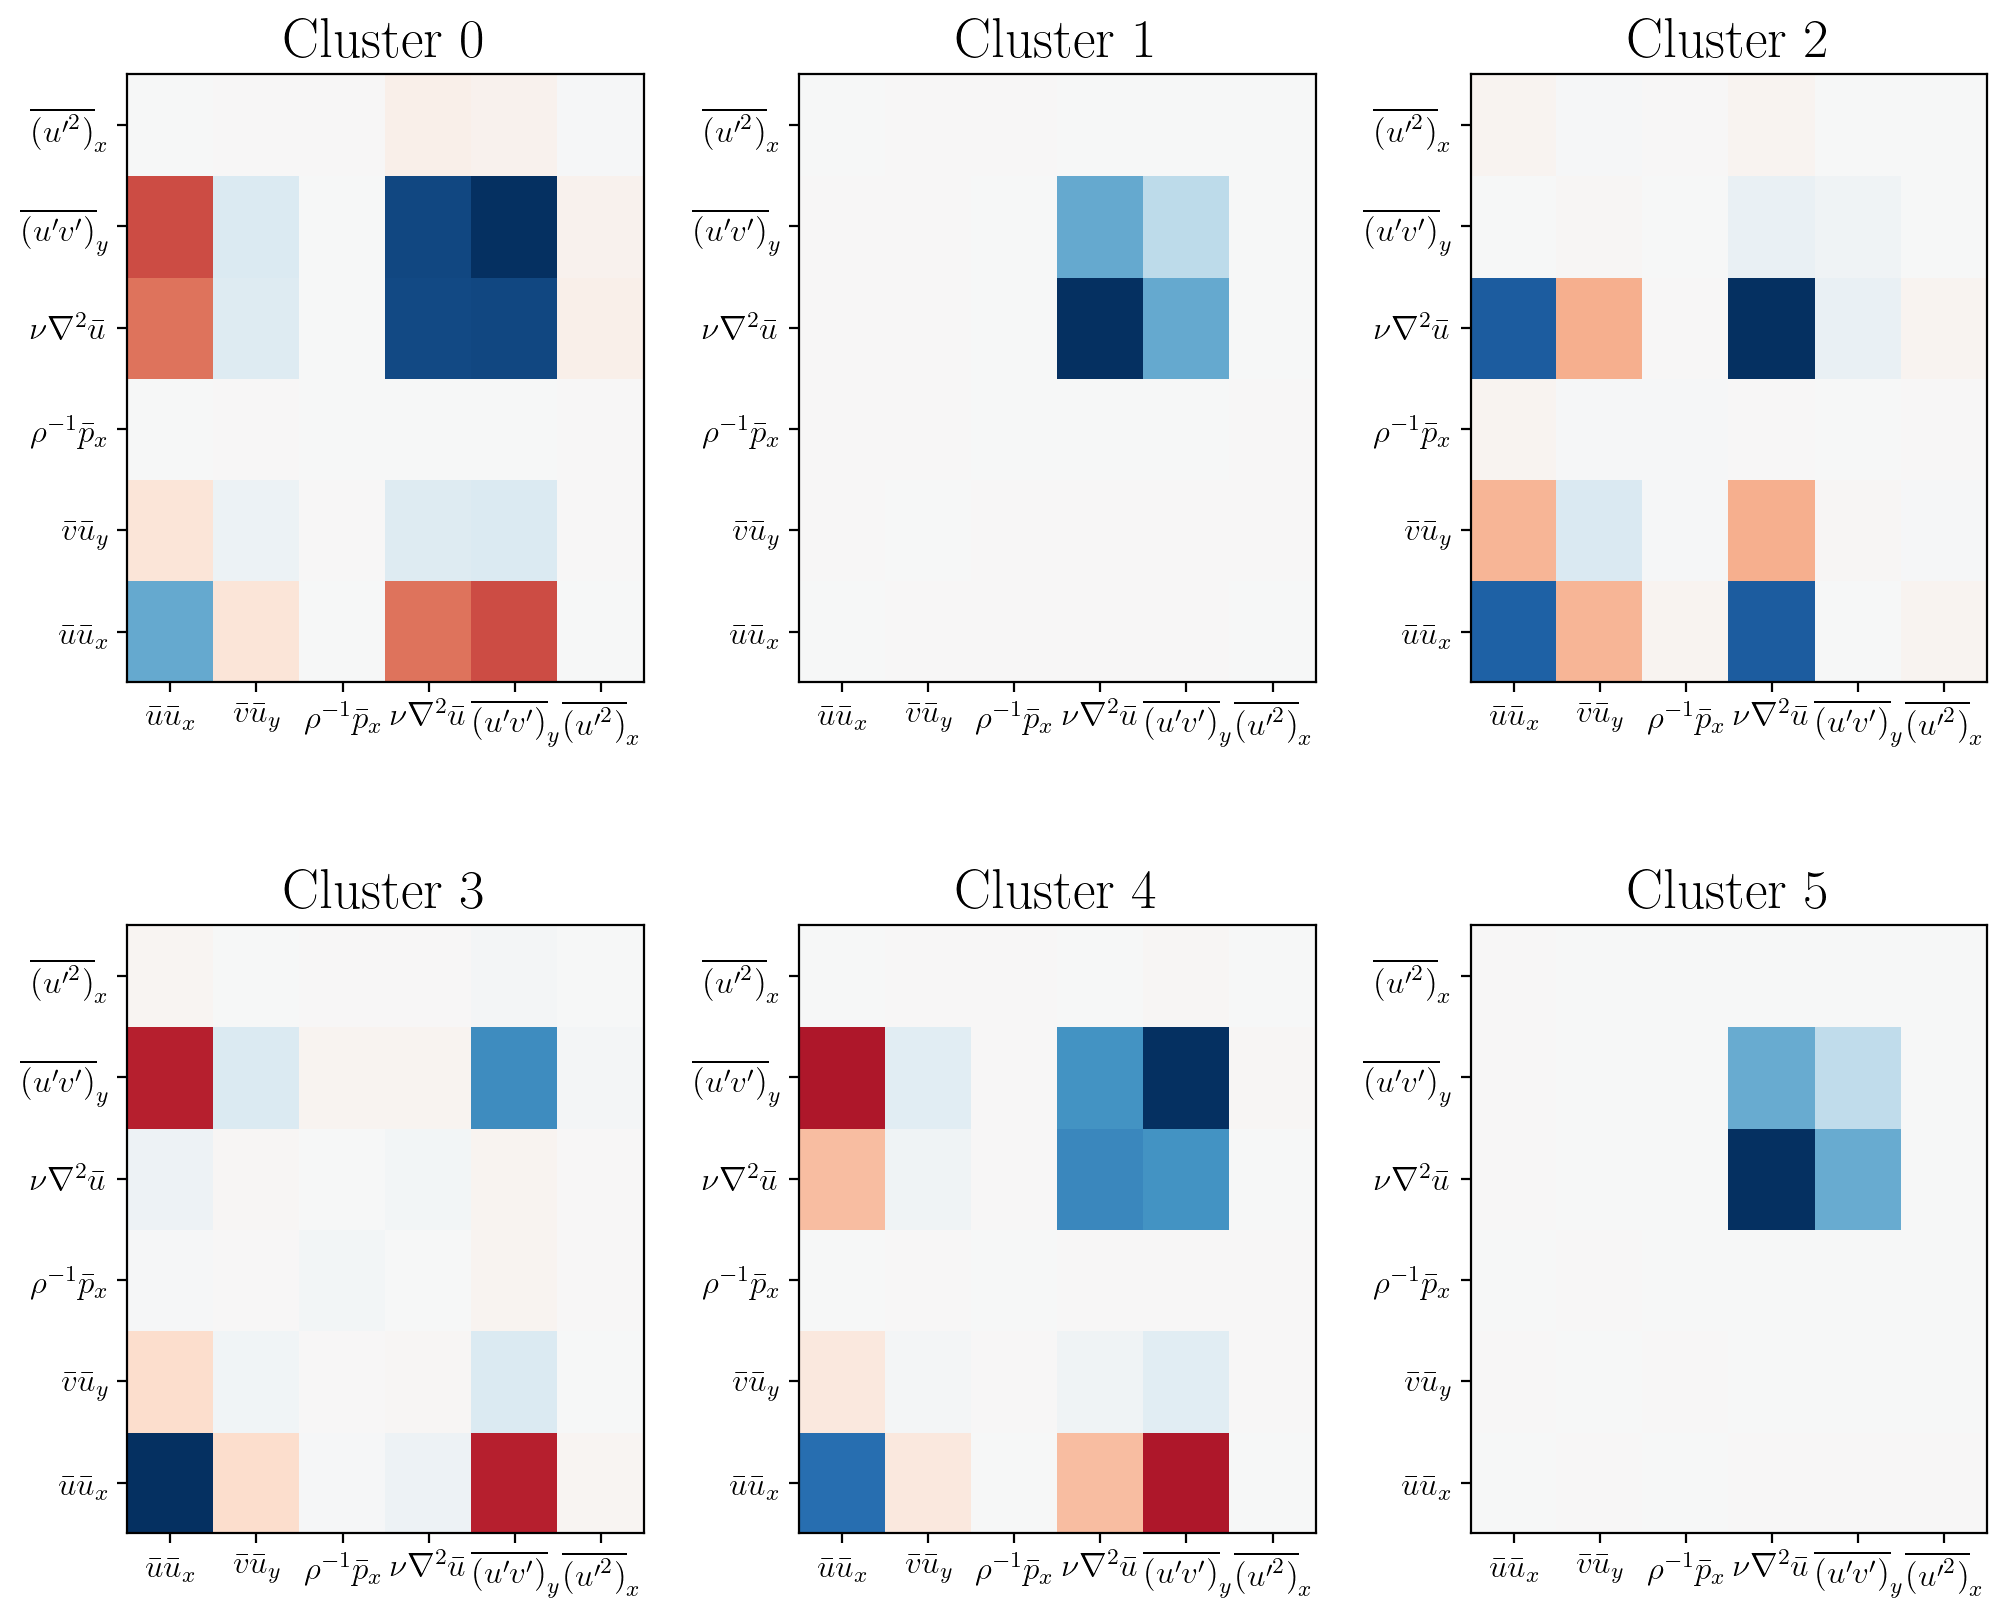

In [ ]:
# Plot covariance matrices for each GMM cluster
pf.plot_cov_mat(model, nfeatures, nc, "GMM")

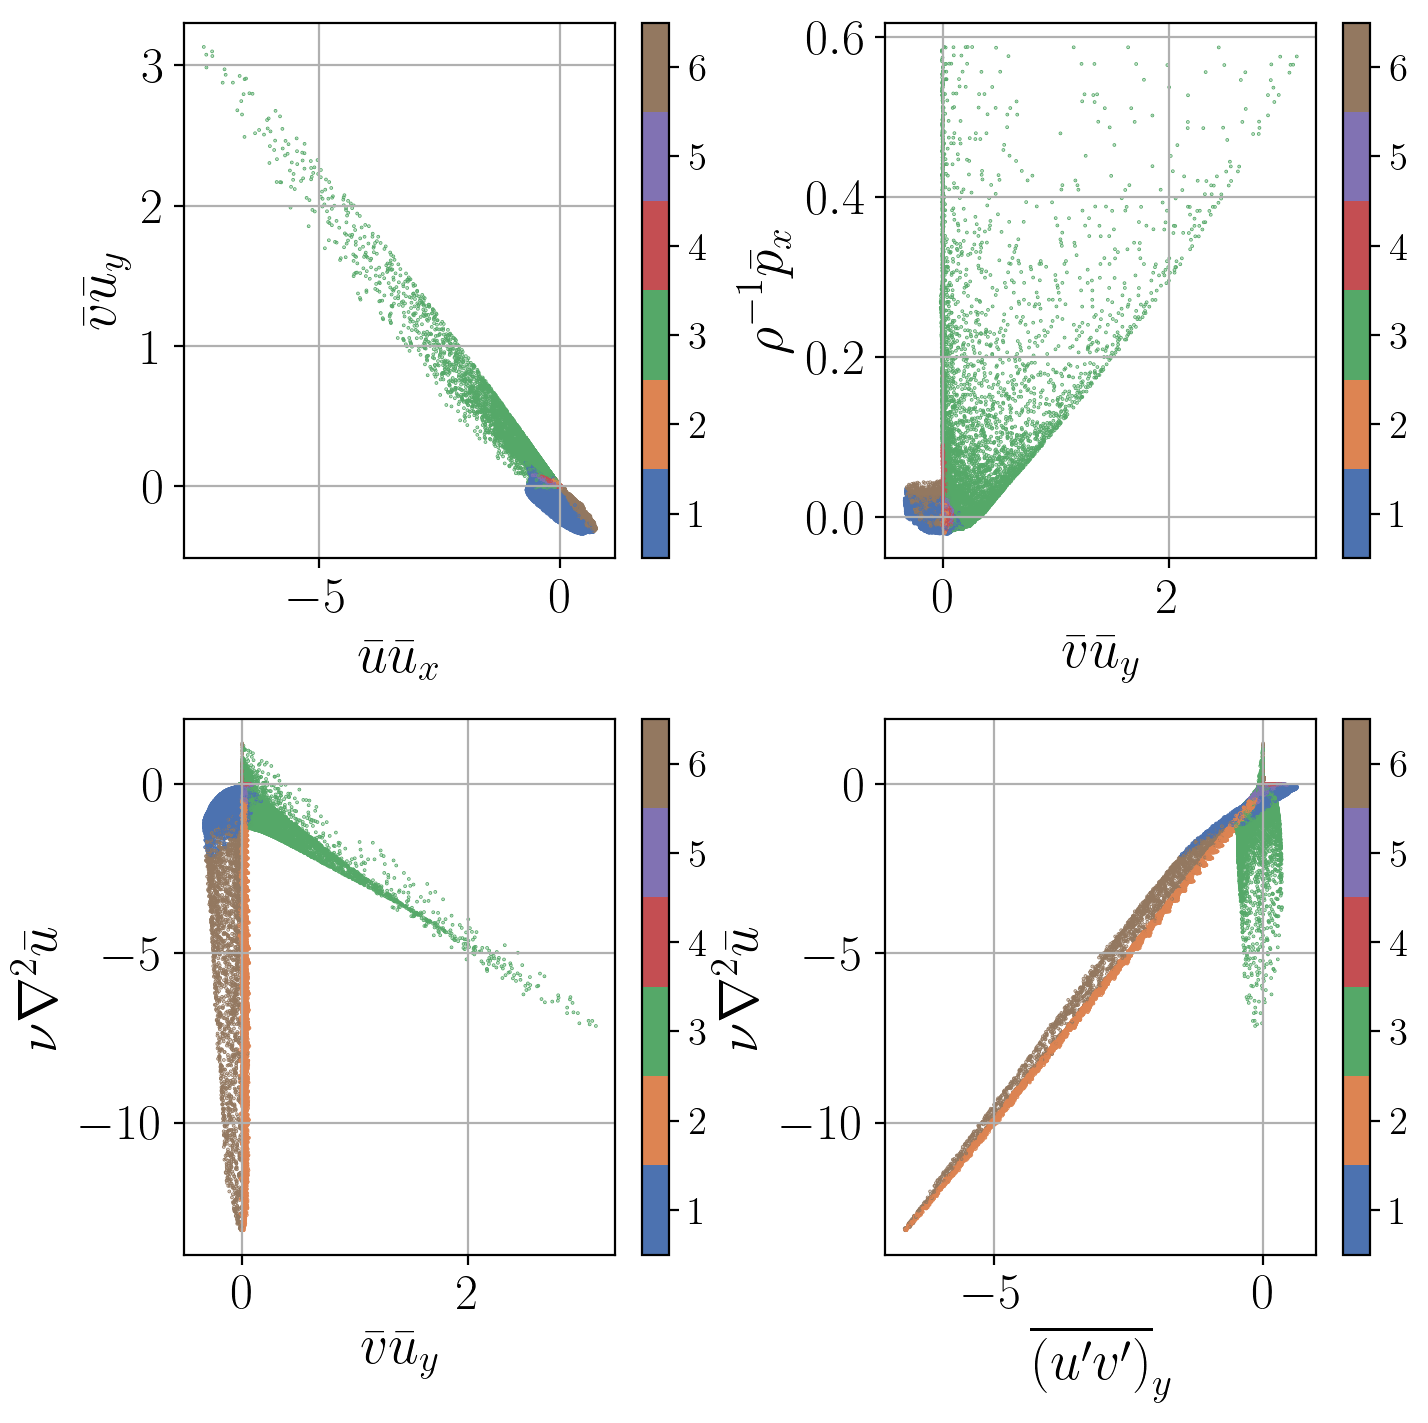

In [ ]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features[mask, :]) + 1
clim = [0.5, cm.N - 0.5]
bounds = np.arange(0.5, nc + 1.5)

pf.plot_clustering_2d_eq_space(features, cluster_idx, mask, nc)

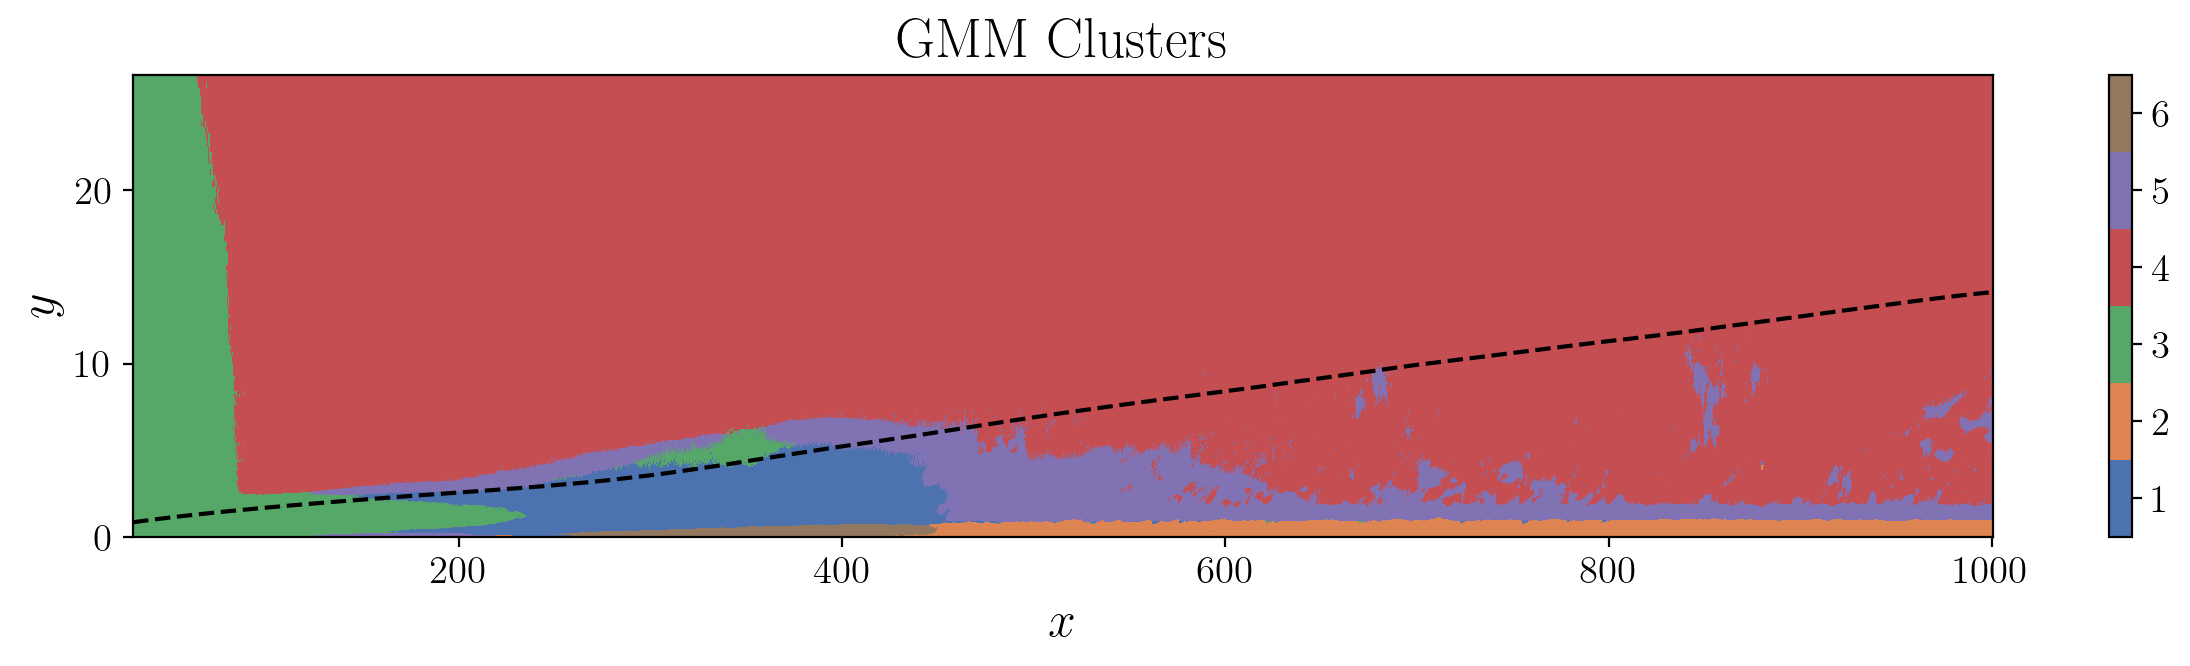

In [ ]:
# Assign points in space to each cluster
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(clustermap, x, y, X, Y, nx, ny, nc, u, U_inf)

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

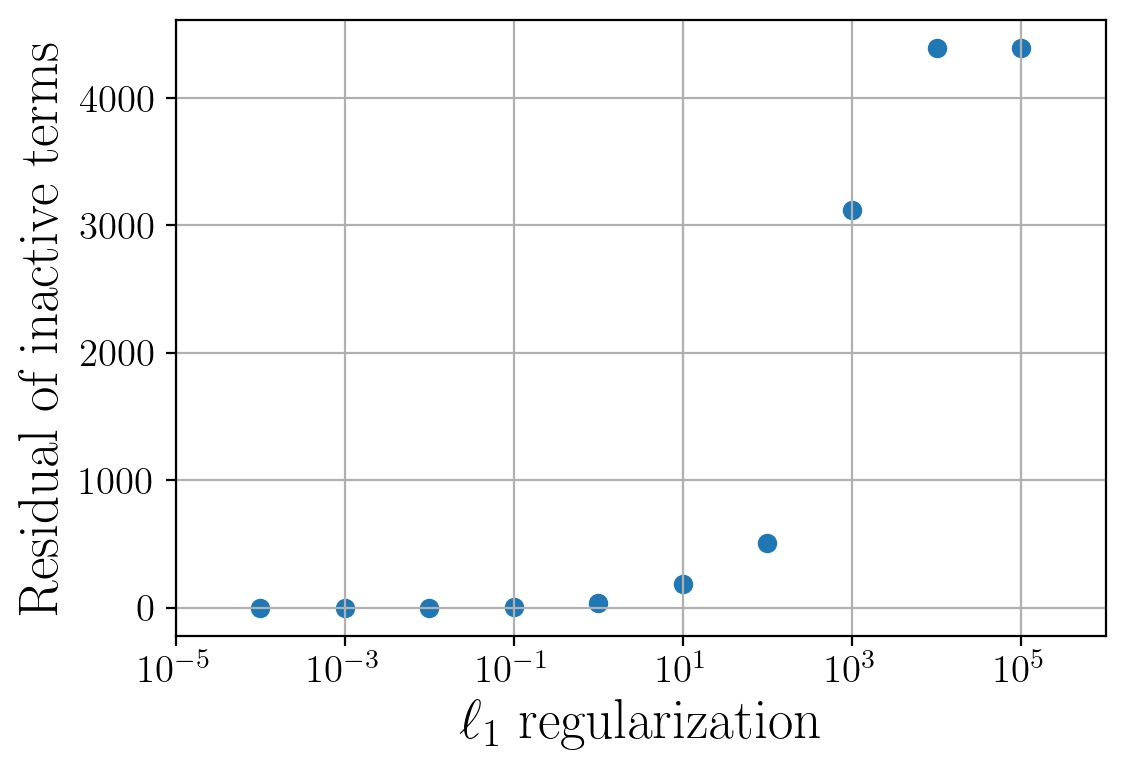

In [ ]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alphas[k])  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err)

In [ ]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 10  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
    spca.fit(cluster_features)

    print("GMM Cluster {0}:".format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set the active terms to 1
    else:
        print("None")

GMM Cluster 0:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 1:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 4:
['$\\bar{u} \\bar{u}_x$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
GMM Cluster 5:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


## c. Resulting Final Dominant Balance Models

In [ ]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print balance models
for i in range(nmodels):
    print("SPCA Cluster {0}:".format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms) > 0:
        print([labels[k] for k in active_terms])
    else:
        print("No dynamics")

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

[[0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1. 0.]]
SPCA Cluster 0:
['$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 1:
['$\\bar{u} \\bar{u}_x$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 2:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\overline{(u^\\prime v^\\prime)}_y$']
SPCA Cluster 3:
['$\\bar{u} \\bar{u}_x$', '$\\bar{v}\\bar{u}_y$', '$\\nu \\nabla^2 \\bar{u}$', '$\\overline{(u^\\prime v^\\prime)}_y$']


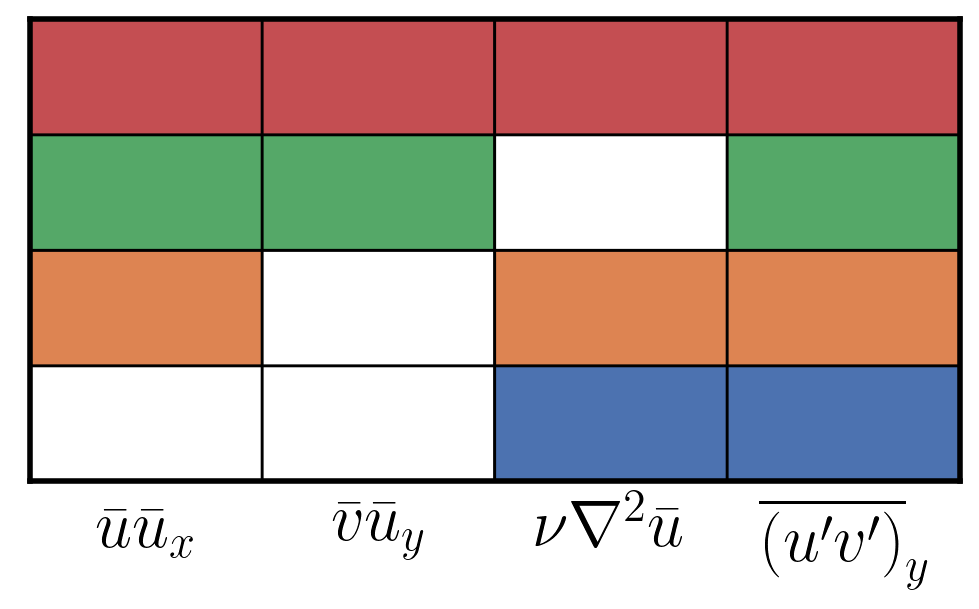

In [ ]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (
    gridmap.T * np.arange(nmodels)
).T + 1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

# Delete zero terms
grid_mask = np.nonzero(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

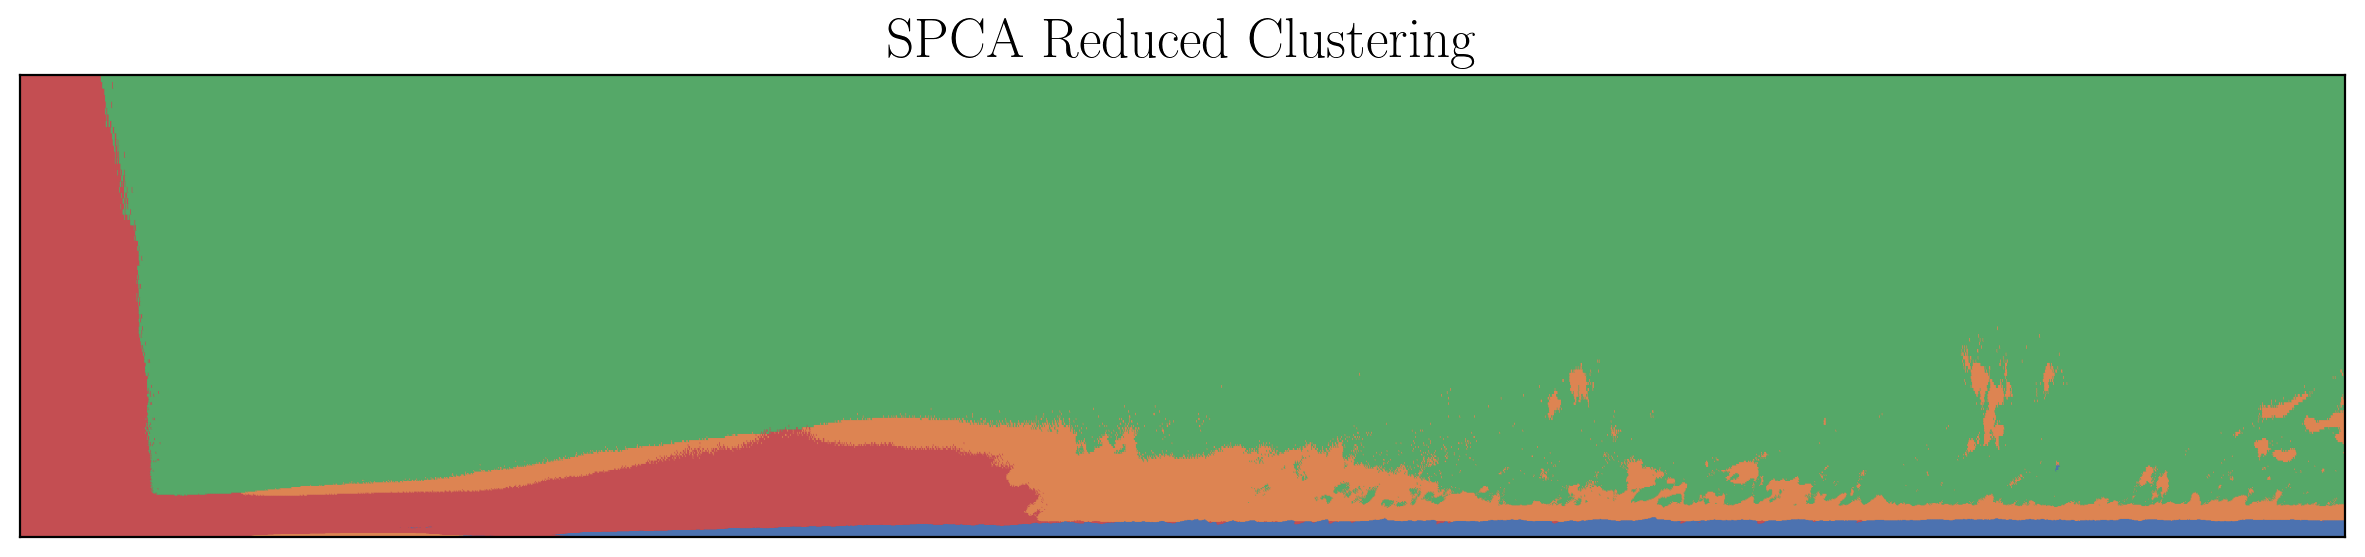

In [ ]:
# Plot the clustering in space after SPCA
pf.plot_spca_reduced_clustering(x, y, balancemap)

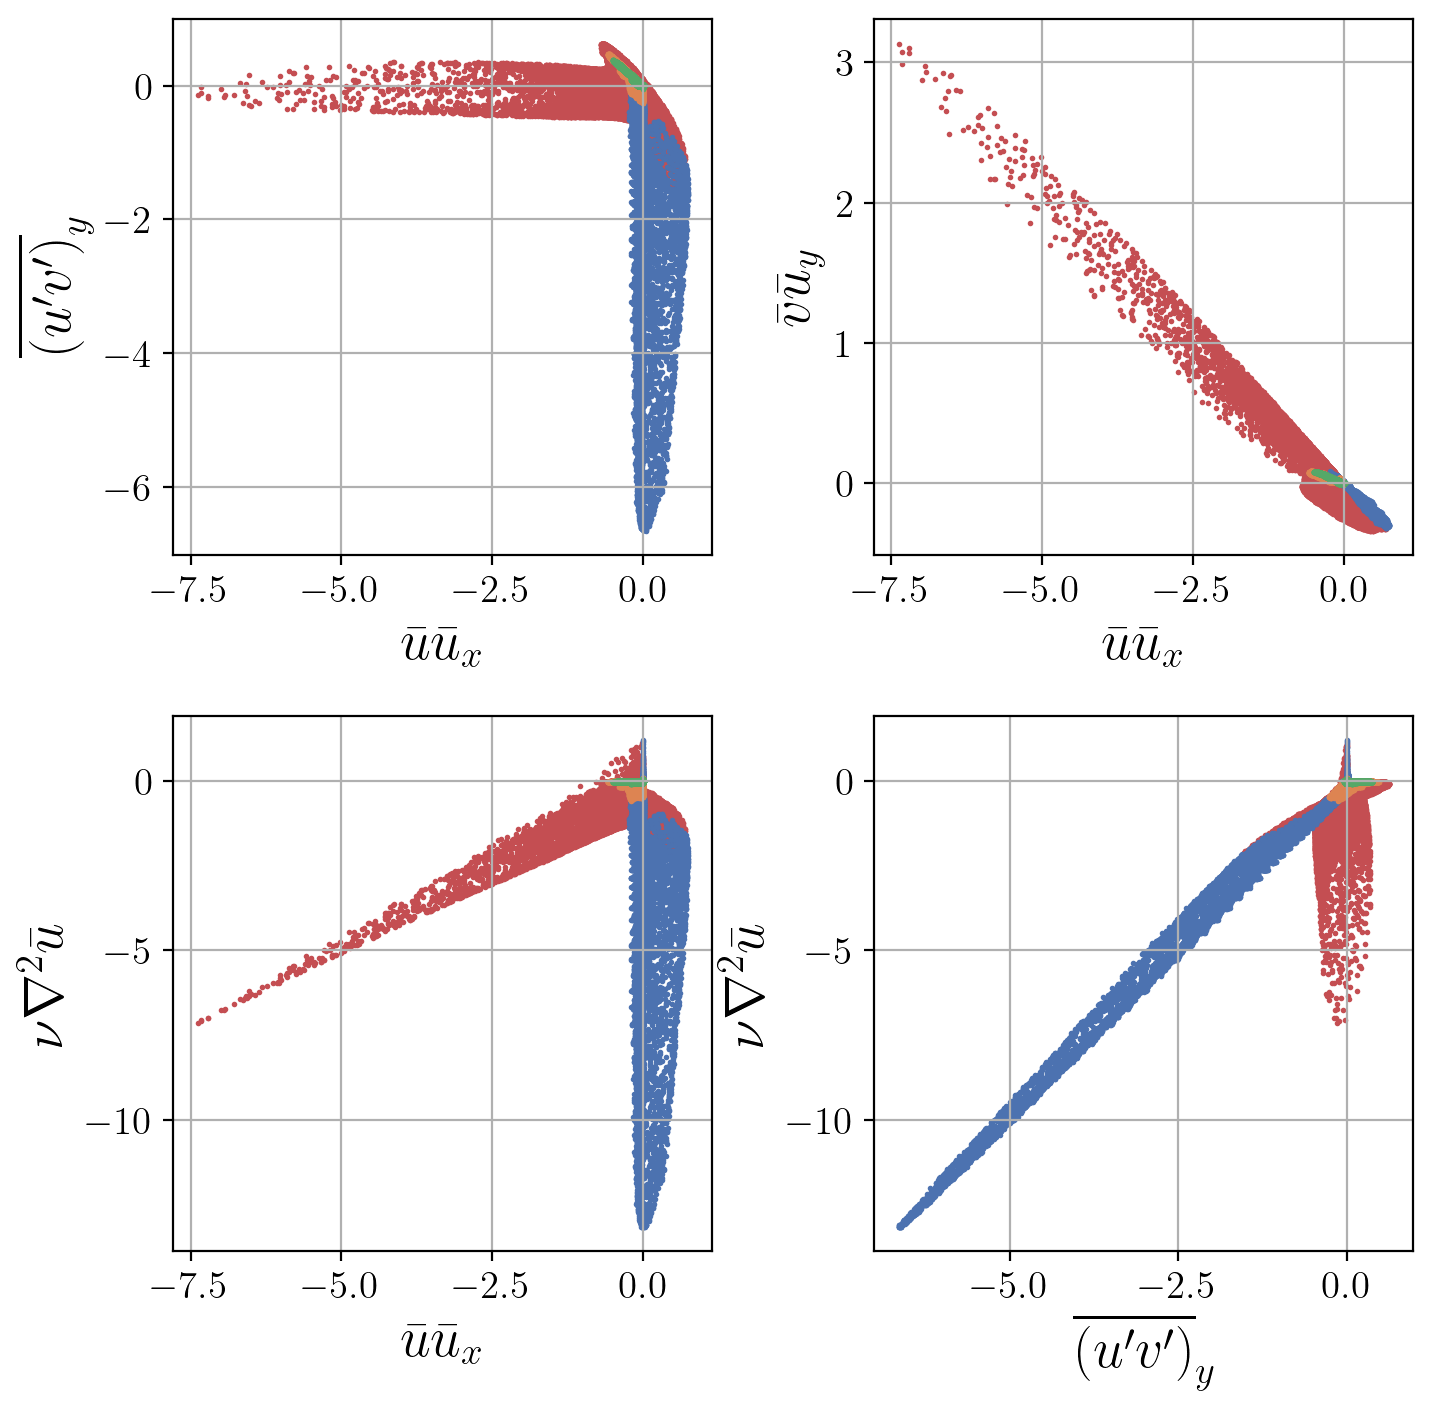

In [ ]:
# 2D views of feature space
pf.plot_feature_space(features, mask, balance_idx)